# Intro

The following code provides you with surprisal values for the same data you used in Homework 2.  The surprisal values are based on the output of an RNN model.

We leave it up to you to perform the alignment between the model output and the reading times!

Feel free to skim through the code, it might be helpful for the semi-structured and open-ended tasks!
This includes the package used to train the RNN model, and compute the surprisals - [https://github.com/omershubi/neural-complexity.git](https://github.com/omershubi/neural-complexity.git).

## Set up dependencies and data

Run the cell below to fetch the recurrent neural network codebase we've designed for this assignment.

It will leave the files in a directory called `rnn` (check in the sidebar after you've run the command).

In [2]:
from google.colab import drive
import pandas as pd
from copy import deepcopy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import copy

import re
from sklearn.metrics import mean_squared_error, r2_score
import nltk
from nltk.tokenize import word_tokenize
from collections import defaultdict
from nltk.util import ngrams
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast
from tqdm import tqdm
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
%%bash
git clone https://github.com/omershubi/neural-complexity.git rnn
mkdir -p rnn/data/ptb

Cloning into 'rnn'...


In [5]:
drive.mount('/content/gdrive')
GDRIVE_DIR = "/content/gdrive/My Drive/096222_project_surprisals_and_rts"
!mkdir -p "$GDRIVE_DIR"
!mkdir -p "$GDRIVE_DIR/corpus_data"
!wget -qO rnn/data/ptb/ptb_tok_train.txt https://gist.githubusercontent.com/omershubi/cdd4231472d6188f03ab21e2b2729fee/raw/e1b4c764561fd038470830534baaa220b0eb4c6d/ptb_tok_train.txt
!wget -qO rnn/data/ptb/ptb_tok_dev.txt https://gist.githubusercontent.com/omershubi/31eff71b74dfb8cfe93d1a9acf8ab523/raw/094d3094b06beb92cd7fd0496710cf43273f8c64/ptb_tok_dev.txt
!cp rnn/data/ptb/* "$GDRIVE_DIR/corpus_data/"
rnn_surprisals = pd.read_csv(f'{GDRIVE_DIR}/rnn_surprisals.tsv',sep=' ')
rnn_surprisals
sprt = pd.read_csv('https://gist.githubusercontent.com/omershubi/01b55eab89b81dc882055e0d27d61016/raw/046dbb7f0586b5dc1a368ee882f2cb923caad3df/brown-spr-data-for-pset.csv', index_col=0).sort_values(by='code')
sprt.to_csv('./sprt_data.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
rnn/data/ptb/ptb_tok_train.txt: No such file or directory
rnn/data/ptb/ptb_tok_dev.txt: No such file or directory
cp: cannot stat 'rnn/data/ptb/*': No such file or directory


# Recurrent neural network modeling

## Train model

Now we're ready to begin training the model. The below command will launch the neural network optimization procedure, and progressively save checkpoints to the Google Drive you've just mounted. The neural network train for 40 epochs (1 epoch = 1 loop through the training dataset), which should take approximately **2 hours**.

Checkpoints will be saved each time the validation loss improves, and named `ptb_model.pt`. Watch the output of the command below to see how the model's train and validation perplexity improve over time.

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/ptb_model.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data" --trainfname ptb_tok_train.txt --validfname ptb_tok_dev.txt

Libraries loaded

^C


## Compute surprisals

Now we'll compute model surprisals for the text data in `brown.txt` (already downloaded for you). This will output a file called `rnn_surprisals.tsv` to your Google Drive, which you'll use in the next steps of the analysis.

We'll load the checkpoint and use it to extract per-token surprisal estimates.

In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/ptb_model.pt"

In [ ]:
#Now we'll compute model surprisals for the text data in brown.txt (already downloaded for you). This will output a file called rnn_surprisals.tsv to your Google Drive, which you'll use in the next steps of the analysis.
#We'll load the checkpoint and use it to extract per-token surprisal estimates.
checkpoint_to_use = f"{GDRIVE_DIR}/ptb_model.pt"
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" --data_dir './data' \
    --testfname 'brown.txt' --test --words --nopp > "$GDRIVE_DIR/rnn_surprisals.tsv"

Libraries loaded
Using beamsize: 23757


## Harmonize RNN surprisal and RT data

Load and align the reading times with the n-gram model surprisals.
You may load the harmonized csv from Homework 2, or align it again.

Finallyy, align the RNN model-derived surprisal values with human reading times. The harmonize function you wrote in Homework 2 may be helpful here too.

Note, modifications may be required as the tokenization is not necessarily the same as the n-gram model.

In [2]:
def harmonize(rt_data: pd.DataFrame, surprs_data: pd.DataFrame, is_rnn=True) -> pd.DataFrame:
    token_key = 'word' if is_rnn else 'token'

    surprisals_df = surprs_data[surprs_data[token_key] != '</s>']
    keys_df = rt_data[['word', 'code', 'text_id', 'text_pos']]
    keys_df = keys_df.drop_duplicates()
    keys_df['text_pos'] = keys_df['text_pos'] + 1
    keys_df = keys_df[~keys_df['word'].str.contains('-')]
    aligned_data = []
    keys_iter = keys_df.iterrows()
    surprisal_iter = surprisals_df.iterrows()
    keys_index, keys_row = next(keys_iter, (None, None))
    surprisals_index, surprisals_row = next(surprisal_iter, (None, None))
    while keys_row is not None and surprisals_row is not None:
        keys_word = keys_row['word']
        surprisal_word = surprisals_row[token_key]
        if keys_word == surprisal_word or surprisal_word == '<unk>':
            #words matchoritisis<unk>
            if is_rnn:
              aligned_data.append({
                  'word': keys_word,
                  'code': keys_row['code'],
                  'text_id': keys_row['text_id'],
                  'text_pos': keys_row['text_pos'],
                  'word_rnn': surprisal_word,
                  'sentence_id': surprisals_row['sentid'],
                  'sentence_pos': surprisals_row['sentpos'],
                  'wlen': surprisals_row['wlen'],
                  # 'token_id': surprisals_row['token_id'],
                  'surprisal': surprisals_row['surp'],
                  'entropy': surprisals_row['entropy'],
                  'entred': surprisals_row['entred']
              })
            else:
              aligned_data.append({
                  'word': keys_word,
                  'code': keys_row['code'],
                  'text_id': keys_row['text_id'],
                  'text_pos': keys_row['text_pos'],
                  'token': surprisal_word,
                  'sentence_id': surprisals_row['sentence_id'],
                  'token_id': surprisals_row['token_id'],
                  'surprisal': surprisals_row['surprisal'],
              })

            keys_index, keys_row = next(keys_iter, (None, None))
            surprisals_index, surprisals_row = next(surprisal_iter, (None, None))
        else:
            #words dontmatch-tetaken
            match_found = False
            keys_backup = [keys_row]
            surprisals_backup = [surprisals_row]
            for _ in range(3):
                keys_index, next_keys_row = next(keys_iter, (None, None))
                if next_keys_row is not None:
                    keys_backup.append(next_keys_row)
                else:
                    break
            for _ in range(3):
                surprisals_index, next_surprisal_row = next(surprisal_iter, (None, None))
                if next_surprisal_row is not None:
                    surprisals_backup.append(next_surprisal_row)
                else:
                    break
            for k_row in keys_backup:
                for s_row in surprisals_backup:
                    if k_row['word'] == s_row[token_key] or k_row['word'] == '<unk>' or s_row[token_key] == '<unk>':
                        if is_rnn:
                          aligned_data.append({
                              'word': k_row['word'],
                              'code': k_row['code'],
                              'text_id': k_row['text_id'],
                              'text_pos': k_row['text_pos'],
                              'word_rnn': s_row[token_key],
                              'sentence_id': s_row['sentid'],
                              'sentence_pos': s_row['sentpos'],
                              'wlen': s_row['wlen'],
                              'surprisal': s_row['surp'],
                              'entropy': s_row['entropy'],
                              'entred': s_row['entred']
                          })
                        else:
                          aligned_data.append({
                              'word': k_row['word'],
                              'code': k_row['code'],
                              'text_id': k_row['text_id'],
                              'text_pos': k_row['text_pos'],
                              'token': s_row[token_key],
                              'sentence_id': s_row['sentence_id'],
                              'token_id': s_row['token_id'],
                              'surprisal': s_row['surprisal'],
                          })


                        match_found = True
                        break
                if match_found:
                    break
            if match_found:
            #move pointerstothenextunmatchedrows
                while keys_backup and not keys_backup[0].equals(k_row):
                    keys_index, keys_row = next(keys_iter, (None, None))
                    keys_backup.pop(0)
                keys_index, keys_row = next(keys_iter, (None, None))
                while surprisals_backup and not surprisals_backup[0].equals(s_row):
                    surprisals_index, surprisals_row = next(surprisal_iter,(None, None))
                    surprisals_backup.pop(0)
                surprisals_index, surprisals_row = next(surprisal_iter, (None,None))
            else:
                #If nomatchfound-skipthemismatchedword
                keys_index, keys_row = next(keys_iter, (None, None))
                surprisals_index, surprisals_row = next(surprisal_iter, (None,None))



    aligned_df = pd.DataFrame(aligned_data)
    if is_rnn:
      aligned_df=aligned_df[['code','wlen','surprisal','entropy','entred']]
    else:
      aligned_df=aligned_df[['code','surprisal']]
    final=pd.merge(rt_data,aligned_df,on='code',how='inner')
    return final

In [ ]:
harmonized_rnn_df = harmonize(sprt, rnn_surprisals, is_rnn=True)
harmonized_rnn_df.to_csv('./harmonized_rnn_df.csv')

## 1. Comparing the models to the reading time
Let us load the values we got from the ngram model for comparison

In [ ]:
ngram_surprisals = pd.read_csv(
    'https://gist.githubusercontent.com/omershubi/f19f77f5157f7ba7ea1adf72a72847da/raw/d5d553b1217ea70fe3261ce5d9a0532f29769817/5gram_surprisals.tsv',
    index_col=False, sep='\t')
ngram_surprisals.to_csv("surprisal.csv")
harmonized_ngram_df = harmonize(sprt, ngram_surprisals, is_rnn=False)
harmonized_ngram_df.to_csv('./harmonized_ngram_df.csv')

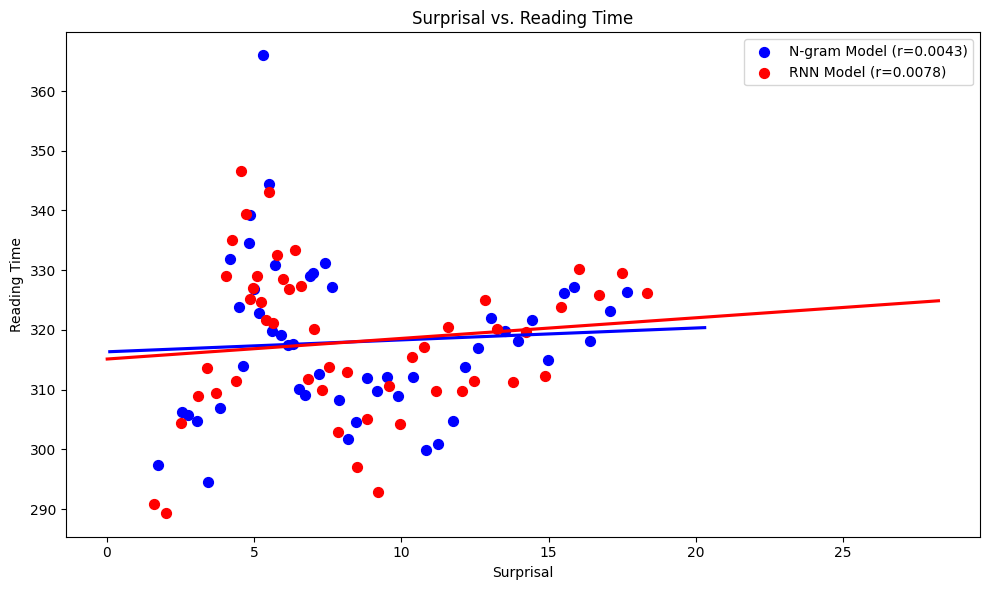

In [ ]:
# Load data
harmonized_ngram = pd.read_csv("harmonized_ngram_df.csv")
harmonized_rnn = pd.read_csv("harmonized_rnn_df.csv")

# Calculate correlation coefficients
corr_ngram, _ = pearsonr(harmonized_ngram['surprisal'], harmonized_ngram['time'])
corr_rnn, _ = pearsonr(harmonized_rnn['surprisal'], harmonized_rnn['time'])

# Plot
plt.figure(figsize=(10, 6))
sns.regplot(x="surprisal", y="time", data=harmonized_ngram, x_bins=50, color='blue', ci=0, label=f'N-gram Model (r={corr_ngram:.4f})')
sns.regplot(x="surprisal", y="time", data=harmonized_rnn, x_bins=50, color='red', ci=0, label=f'RNN Model (r={corr_rnn:.4f})')

# Add titles and labels
plt.title('Surprisal vs. Reading Time')
plt.xlabel('Surprisal')
plt.ylabel('Reading Time')

# Add a legend
plt.legend()

plt.tight_layout()
plt.show()


We can see that the RNN is slightly better correlated then the ngram model, but not by alot. We can see that the diffrences are small, but it seems the NGram model underestimates the delay of reading time, especially in the higher surprisal values, while the RNN encapsulate those slightly better.

## 2. Relationship between surprisal values of both models

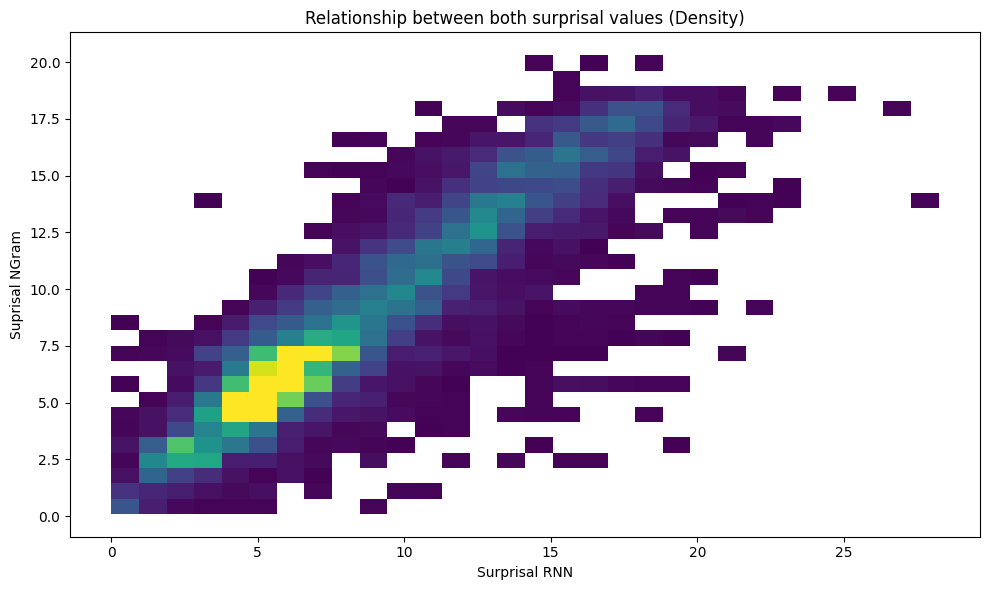

In [ ]:
# Load data
harmonized_ngram = pd.read_csv("harmonized_ngram_df.csv")
harmonized_rnn = pd.read_csv("harmonized_rnn_df.csv")

# Create a DataFrame for both surprisal values
suprisals_both = pd.DataFrame({
    'surprisal_ngram': harmonized_ngram['surprisal'],
    'surprisal_rnn': harmonized_rnn['surprisal']
})

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(x="surprisal_rnn", y="surprisal_ngram", data=suprisals_both, bins=30, pmax=0.8, cmap='viridis')

# Add titles and labels
plt.title('Relationship between both surprisal values (Density)')
plt.xlabel('Surprisal RNN')
plt.ylabel('Suprisal NGram')

plt.tight_layout()
plt.show()


We can see that the models agree quite often, especially in the low-mid values (5-7.5) and disagree more often as soon as we get further from these values.
We can also see from the splash to the left that the RNN is usually more surprised then the ngram model when they disagree.

## 3. Examples - points of disagreement between the models
We want to seperate the cases - we will set a threshold and will see when the disagreement happens since the rnn is higher then the ngram model, and vice versa.

In [ ]:
threshold = 7
ngram_high = harmonized_rnn.iloc[suprisals_both[suprisals_both['surprisal_ngram'] - suprisals_both['surprisal_rnn'] > threshold].index]
rnn_high = harmonized_rnn.iloc[suprisals_both[suprisals_both['surprisal_rnn'] - suprisals_both['surprisal_ngram'] > threshold].index]

In [ ]:
rnn_high['word'].unique()

array(['Today', 'may', 'corps', 'first', 'officer', 'eyes', 'He', 'His',
       'In', 'She', 'John', 'is', 'frequency', 'The', 'stream', 'Drug',
       'shore', 'away', 'Street', 'York,', 'tracks', 'out', 'There',
       'was', 'engines', 'I', 'Hampshire,', 'Englander,', 'Mrs.', 'feel',
       'the', 'We', 'Then', 'west', 'Guinea,', 'our', 'us', 'But',
       'street', 'By', 'South', 'had'], dtype=object)

In [ ]:
ngram_high['word'].unique()

array(['feet', 'Guard', 'As', 'The', 'Pauson:'], dtype=object)

For the engram lets go with the word "feet". Well print the text with the corresponding ID.

In [ ]:
ngram_high[ngram_high['word']=='feet']['text_id'].unique()

array([6])

So we'll print text 6:

In [ ]:
" ".join(sprt[sprt['text_id']==6]['word'].unique())

'Bong! Startled him awake. The room vibrated as if a giant hand had rocked it. A dull boom and throbbing echo. walls bulged, the floor trembled, windowpanes rattled. He stared at far morning, expecting pendulum to swing across horizon. raced window yanked sash. wood was old, paint alligatored. fresh breeze saluted him. Six o\'clock! put his head out. There slate roof of church; ivy climbed red brick like green-scaled monster. clock which struck presented an innocent face. In kitchen Mama wiping cupboards. "There\'s tower steeple on church million feet high. And loudest in whole world!" "I know, Stephen," she smiled. "They say that our is one hundred sixty-two you heard strike -- it\'s really town clock -- installed last April by Mrs. Shorter, her birthday." dressed, sped outdoors. crossed Broome Street Orange Square. leaned backward, while advanced headless creature long, shapeless coat. spire seemed hold up sky. Port Jervis, basking foothills, city God. Dutch Reformed Church, with two

The word feet appears in the sentense: "There's tower steeple on church million feet high". This example is from the case that the ngram model gave a high surprisal score compare to the rnn model.
We can see the issue is with "feet" is a measurment unit and a body part, so it makes sense.
Let's search for another one, this time for the word "Guard".

In [ ]:
ngram_high[ngram_high['word']=='Guard']['text_id'].unique()

array([8])

In [ ]:
" ".join(sprt[sprt['text_id']==8]['word'].unique())

'Buffeted by swirling winds, the little green biplane struggled northward between mountains beyond Northfield Gulf. Wires whined as a cold November blast rocked silver wings, but engine roar was reassuring to pilot bundled in open cockpit. He peered ahead and grinned railroad tracks came into view again below. "Good old iron compass!" thought. A plume of smoke rose from Central Vermont locomotive which idled behind string gravel cars, figures that were workmen labored set ruptured roadbed rights. The girders shattered Dog River bridge lay strewn for half mile downstream. Vermont\'s main line prostrate. And dark days after Great Flood 1927 -- worst natural disaster state\'s history -- plane its sole replacement carrying United States mails. Rain near cloudburst proportions had fallen three full it still raining on morning Friday, 4, 1927, when officials Post Office Department\'s Railway Mail Service realized their distribution system been almost totally destroyed overnight. Clerks postm

The word appear in this context:
"But what piling up. nearest undisrupted end track Boston Concord, N. H. When Governor Al Smith offered New York National Guard planes fly state, seemed likely temporary solution, easing Burlington\'s bottleneck Montpelier too."
We can see the same problem - guard is usually a verb the means protecting, but in this case it is the name of the armed forces. It seems the ngram model doesn't do well with words that have multiple meanings.

Let's look for the RNN examples:
We can already see the words: York, Hampshire, Guinea. It's obvious the words "new" is problematic since it's very commonly used as an adjective and not in a name.
Let's look at the word "shore" as well:

In [ ]:
rnn_high[rnn_high['word']=='stream']['text_id'].unique()

array([4])

In [ ]:
" ".join(sprt[sprt['text_id']==4]['word'].unique())

'Franklin D. Lee proved a man of prompt action when Mrs. Claire Shaefer, accompanied by friend, visited him in Bakersfield, California, several months ago as prospective patient. "Doctor" asked her to lie down on bed and remove shoes. Then, squeezing foot three times, he came up -- presto -- with different diagnosis each squeeze. She had -- informed her -- kidney trouble, liver severe female disorder. (He explained that could diagnose these ailments from because all the nervous system was connected it.) He knew just thing for treatment his "cosmic light ozone generator" machine. As applied applicator extending machine -- which consisted seven differently colored neon tubes superimposed rectangular base -- supposedly diseased portions Shaefer\'s body, kept up steady stream pseudo-scientific mumbo-jumbo. Yes, machine would cure practically everything, assured her. Did she know, asked, why colors were important people\'s health? The human body -- pointed out, example -- required 33 units 

The sentence is:
" kept up steady stream pseudo-scientific mumbo-jumbo." It seems the word stream, just like the word now, is very frequant in it's original use, and the RNN model find the disambiguate words that are very frequant.
For this reason he also fails with a lot of stop words such as He, His, She, is, the...
Furthermore it seems that when there is a disagreement the RNN is usually the one to score higher in surprisal. It might be relying to heabvily on the frequancy of the word.

## Spilover effect

In [ ]:
harmonized_ngram_df[harmonized_ngram_df['subject'] == 's001']

,word,code,subject,text_id,text_pos,word_in_exp,time,surprisal
7,In,17000,s001,0,0,2285,399.90,4.57937
26,Ireland's,17001,s001,0,1,2286,529.87,7.45049
34,County,17002,s001,0,2,2287,326.35,12.65410
53,"Limerick,",17003,s001,0,3,2288,651.06,6.11317
73,near,17004,s001,0,4,2289,359.32,12.22380
...,...,...,...,...,...,...,...,...
129497,as,35759,s001,12,759,1650,341.56,9.42416
129518,a,35760,s001,12,760,1651,324.89,3.23962
129553,leader,35761,s001,12,761,1652,518.98,12.81650
129571,and,35762,s001,12,762,1653,344.79,5.90348


First we match every word and it's next word. We need to make sure the subject matches as well, since it could change the effect:

In [ ]:
def align_next_words(df):
    df_next_words = df[['word','subject', 'text_id', 'text_pos', 'time', 'surprisal']].copy()
    df_next_words['text_pos'] -= 1
    df_merged = df.merge(df_next_words, on=['subject', 'text_id', 'text_pos'], suffixes=('', '_next'), how='inner')
    df_merged['prob'] = 2**(-df_merged['surprisal'])
    df_merged = df_merged[['word','word_next','prob','time','time_next']]
    return df_merged

# Assuming harmonized_ngram_df is already defined
ngram_next = align_next_words(harmonized_ngram_df)
rnn_next = align_next_words(harmonized_rnn_df)

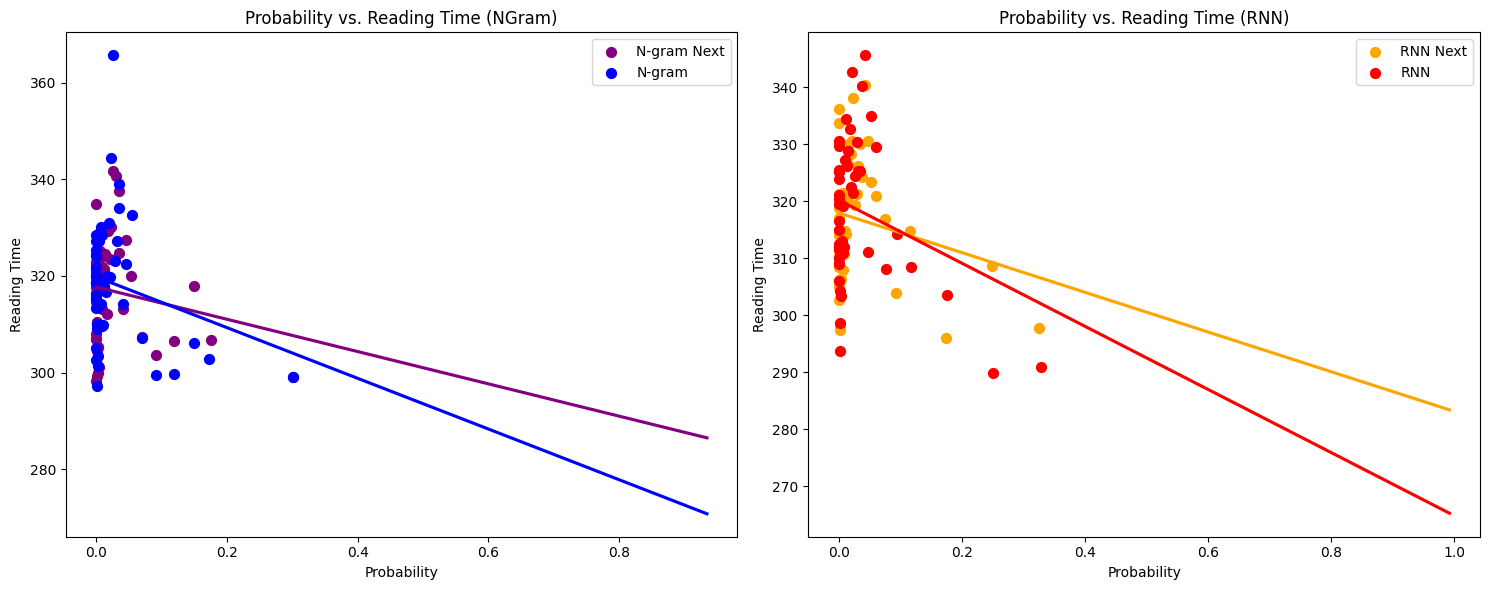

In [ ]:
harmonized_ngram_temp = copy.deepcopy(harmonized_ngram)
harmonized_ngram_temp['prob']= 2**(-harmonized_ngram_temp['surprisal'])
harmonized_rnn_temp = copy.deepcopy(harmonized_rnn)
harmonized_rnn_temp['prob']= 2**(-harmonized_rnn_temp['surprisal'])

# Create subplots for next word reading time and main word reading time
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot next word reading time
sns.regplot(x="prob", y="time_next", data=ngram_next, x_bins=50, color='purple', ci=0,
            label=f'N-gram Next', ax=ax[0])
sns.regplot(x="prob", y="time_next", data=rnn_next, x_bins=50, color='orange', ci=0,
            label=f'RNN Next', ax=ax[1])

# Plot main word reading time
sns.regplot(x="prob", y="time", data=harmonized_ngram_temp, x_bins=50, color='blue', ci=0,
            label=f'N-gram', ax=ax[0])
sns.regplot(x="prob", y="time", data=harmonized_rnn_temp, x_bins=50, color='red', ci=0,
            label=f'RNN', ax=ax[1])

# Add titles and labels for the plots
ax[0].set_title('Probability vs. Reading Time (NGram)')
ax[1].set_title('Probability vs. Reading Time (RNN)')
for a in ax:
    a.set_xlabel('Probability')
    a.set_ylabel('Reading Time')
    a.legend()

plt.tight_layout()
plt.show()


We can clearly see the spilover effect - the X axis is the probability calculated as

$p=2^{-surprisal}$

Where the surprisal value is of the current word (X axis) and two lines - one for the RT of the current word and one for RT of the next word.
We notice that as a general the spilover effect holds - the next word's RT is bigger then the current's word reading time.
What is surprising is that at the extrem for very rare words, the table shifts.
It makes sense - word that are so unexpected are alot of time's unknown to the readers, or so special they try to understand how to pronunce it while reading it.
Although it makes sense it's still a surprising fact, which we couldn't guess would happened.

# **Semi-Structured Part 1: Fitting and plotting the RT surprisal curve using a General Additive Model (GAM)**

In [4]:
!pip install pygam
!pip install wordfreq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 22.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 2.2 MB/s eta 0:00:00


In [3]:
# Preprocessing function to clean the words
def preprocess_word(word):
    word = word.lower()
    word = re.sub(r'[^\w\s]', '', word)
    return word

# Function to calculate log frequency
def calculate_log_frequency(word):
    freq = word_frequency(word, 'en')
    return np.log(freq) if freq > 0 else 0

# Main function to fit the GAM, plot the results, and calculate metrics
def plot_with_gam(data, proc_word=False, plot_real_data=False):
    # Preprocess words
    if proc_word:
        data['proc_word'] = data['word'].apply(preprocess_word)
    else:
        data['proc_word'] = data['word']

    # Calculate log-frequency and word length
    data['log_freq'] = data['proc_word'].apply(calculate_log_frequency)
    data['word_length'] = data['word'].apply(len)

    # Define the predictors (X) and the response variable (y)
    y = data['time'].values  # Convert to numpy array for consistency

    models = {
        'No Control\nVariables': (data[['surprisal']], LinearGAM(s(0))),
        'Word Length\nOnly': (data[['surprisal', 'word_length']], LinearGAM(s(0) + s(1))),
        'Log Frequency\nOnly': (data[['surprisal', 'log_freq']], LinearGAM(s(0) + s(1))),
        'Both': (data[['surprisal', 'log_freq', 'word_length']], LinearGAM(s(0) + s(1) + s(2)))
    }

    plt.figure(figsize=(14, 12))

    metrics = {}

    for i, (label, (X, gam)) in enumerate(models.items()):
        gam.fit(X, y)
        predictions = gam.predict(X)

        # Calculate metrics
        mse = mean_squared_error(y, predictions)
        r2 = r2_score(y, predictions)
        metrics[label] = (mse, r2)

        # Plot predictions
        plt.subplot(2, 2, i+1)
        if plot_real_data:
            plt.scatter(data['surprisal'], y/15 + np.median(y), label='Actual RT', alpha=0.5)
        plt.scatter(data['surprisal'], predictions, color='red', label='Fitted RT', alpha=0.5)
        plt.xlabel('Surprisal')
        plt.ylabel('Reading Time (RT)')
        plt.legend()
        plt.title(f'{label} - RT vs Surprisal')
        plt.ylim([250,600])

    plt.tight_layout()
    plt.show()

    # Plot MSE and R^2 for each model
    plt.figure(figsize=(12, 10))
    labels = list(metrics.keys())
    mse_values = [metrics[label][0] - 40000 for label in labels]
    r2_values = [metrics[label][1] for label in labels]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(1,2,figsize=(8, 4))
    bars1 = ax[0].bar(x - width/2, mse_values, width, label='MSE')
    bars2 = ax[1].bar(x + width/2, r2_values, width, label='R^2')

    ax[0].bar_label(bars1)
    ax[1].bar_label(bars2, fmt='%.4f')


    ax[0].set_title('MSE Performance Metrics (Centered around 40K)')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(labels, rotation=0, ha="center", size=8)

    ax[1].set_title('R-squared Performance Metrics')
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(labels, rotation=0, ha="center",size=8)

    plt.show()
    return gam

In [6]:
## Initializing the variables again.

from pygam import LinearGAM, s
from wordfreq import word_frequency
def align_next_words(df,is_rnn=True):
    df_next_words = df[['word','subject', 'text_id', 'text_pos', 'time', 'surprisal']].copy()
    df_next_words['text_pos'] -= 1
    df_merged = df.merge(df_next_words, on=['subject', 'text_id', 'text_pos'], suffixes=('', '_next'), how='inner')
    df_merged['prob'] = 2**(-df_merged['surprisal'])
    if is_rnn:
          df_merged = df_merged[['word','word_next','prob','time','time_next','word_in_exp','surprisal','surprisal_next', 'wlen']]
    else:
          df_merged = df_merged[['word','word_next','prob','time','time_next','word_in_exp','surprisal','surprisal_next']]

    return df_merged
rnn_surprisals = pd.read_csv(f'{GDRIVE_DIR}/rnn_surprisals.tsv',sep=' ')
rnn_surprisals
sprt = pd.read_csv('https://gist.githubusercontent.com/omershubi/01b55eab89b81dc882055e0d27d61016/raw/046dbb7f0586b5dc1a368ee882f2cb923caad3df/brown-spr-data-for-pset.csv', index_col=0).sort_values(by='code')
sprt.to_csv('./sprt_data.csv')
harmonized_rnn_df = harmonize(sprt, rnn_surprisals, is_rnn=True)
harmonized_rnn_df.to_csv('./harmonized_rnn_df.csv')
ngram_surprisals = pd.read_csv(
    'https://gist.githubusercontent.com/omershubi/f19f77f5157f7ba7ea1adf72a72847da/raw/d5d553b1217ea70fe3261ce5d9a0532f29769817/5gram_surprisals.tsv',
    index_col=False, sep='\t')
ngram_surprisals.to_csv("surprisal.csv")
harmonized_ngram_df = harmonize(sprt, ngram_surprisals, is_rnn=False)
harmonized_ngram_df.to_csv('./harmonized_ngram_df.csv')
ngram_next = align_next_words(harmonized_ngram_df, False)
rnn_next = align_next_words(harmonized_rnn_df)

Testing Function for GAM model :

We created a function that configures the model with a choice of control parameters (word log-frequancy and word length) - that way we can see the added value each control variable claims.
Since the dataset is rather small we used the wordfreq library for the words frequancy. For this reason we also needed to process the words diffrenetly (we just used lower case and removed all symbols that are not letters).
We used a transformation on the real data - we divided by 15 (after trial and error) and subtracted the median of the reading time. It's interesting to see that the data fits very well afterwards. Because it's sort of a linear transformation (we could've used mean instead of median but it was worse for some reason) and the GAM model will fit the model in a linear manner with different denominators. It's the shape of the model that count as long as the transformation is linear.

# RNN Surprisal values VS RTs
We ran the function for both the values and "next" values for the spill-over effect.


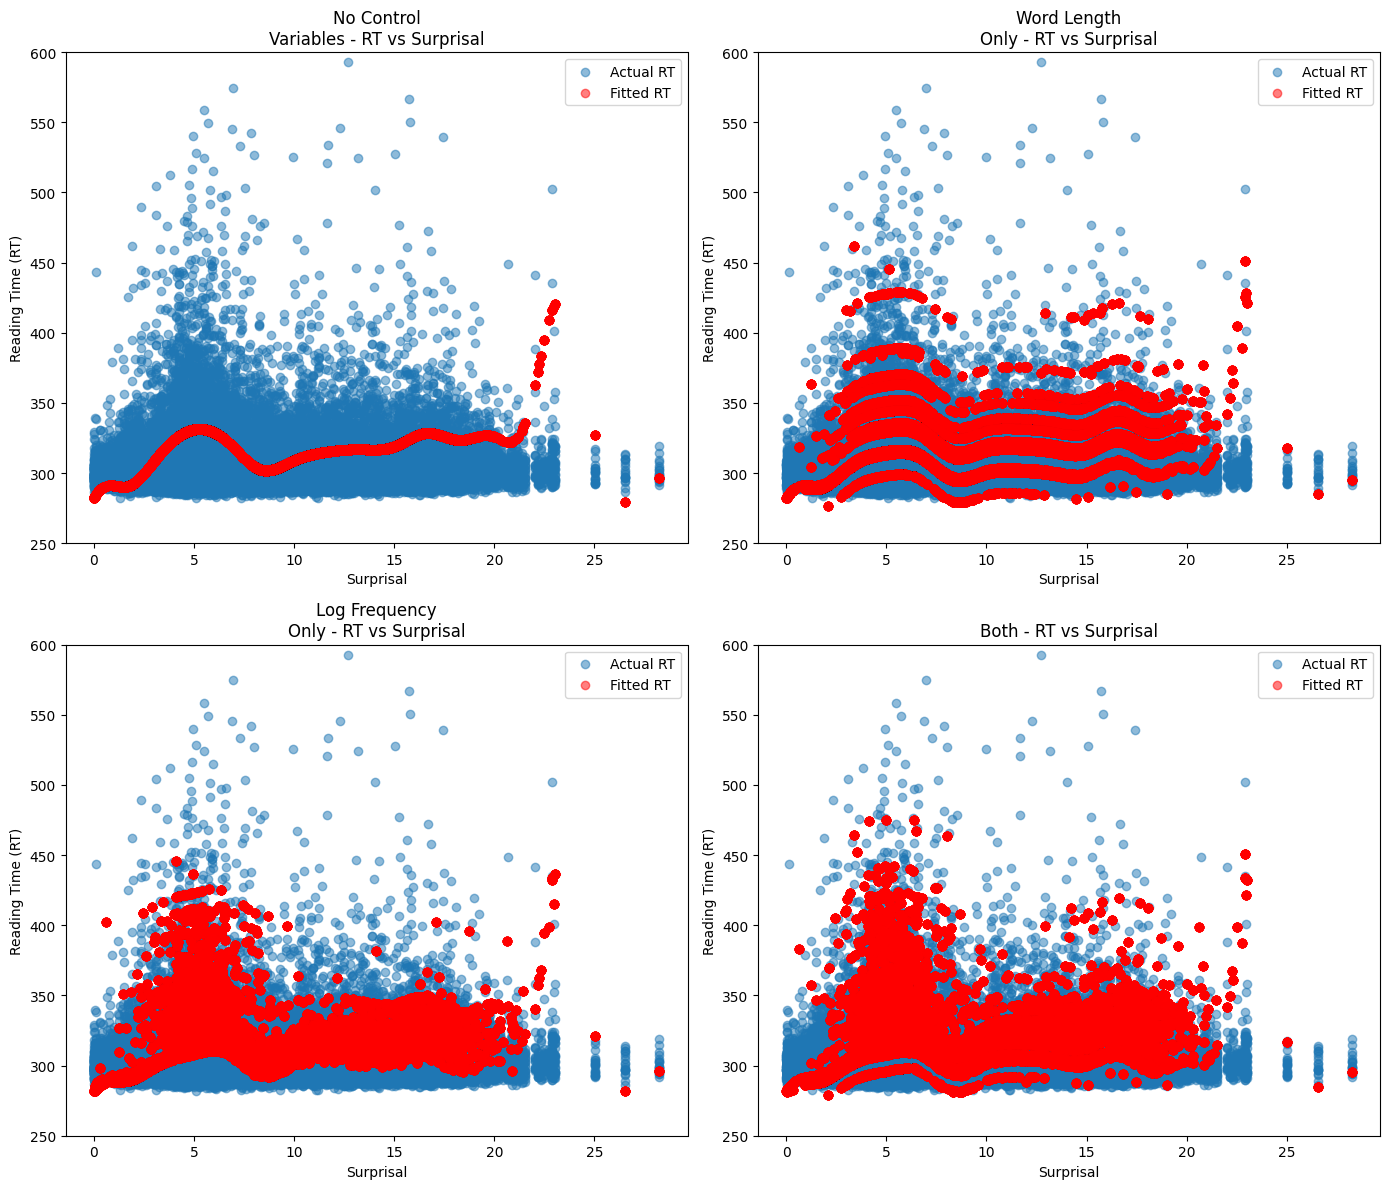

<Figure size 1200x1000 with 0 Axes>

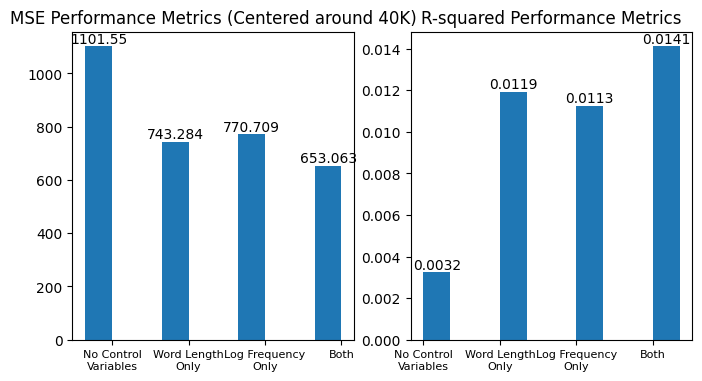

In [ ]:
gam_rnn = plot_with_gam(harmonized_rnn_df, proc_word=True,plot_real_data=True)

### How good does each of the models fit?
We'll start with the model with no control variables. We can see the line does encapsulate the general form of the actual data - but it's missing a lot of variability.
After adding the word length variable we can see lines are forming - this makes sense since it's a discrete variable. But from this we can see it indeed captures a lot of depth the naked model coulden't.
If we use only word frequancy it's we can see it's added value compare to the word length - word length is giving more information about the amplitude of the reading time - how extreme the RTs will get, while the frequancy focuses on the accuracy by being continues and charactarizing every word instead of its group (i.e., "good" belongs to the group of four letter words).

Finally in the "both" model we can see exactly that - the model is much more dense compare to the "Word Length Only" model by utilizing the frequancies, and much higher and extreme (when needed) compare to the "Log Frequancy Only" model - utilizing the word length column.



### Weight of Control Variables:
First we already notice the weight the GAM model has showen us for every control variable - every control variable is giving a lot of information compare to a "naked" model with only surprisal values.
Although each variable contributes a lot, we can see the the contribution of moving from one control variable to both of them improves the predictions only by a bit.

This means that the variables are not independent, and that makes sense, since people tend to use shorter words more frequantly. That means the information we gain from both variables is overlapping quite a bit.
Never the less - we could still capture through the graphs what each one contributes uniquely.

## Comparing with the spill-over effect data

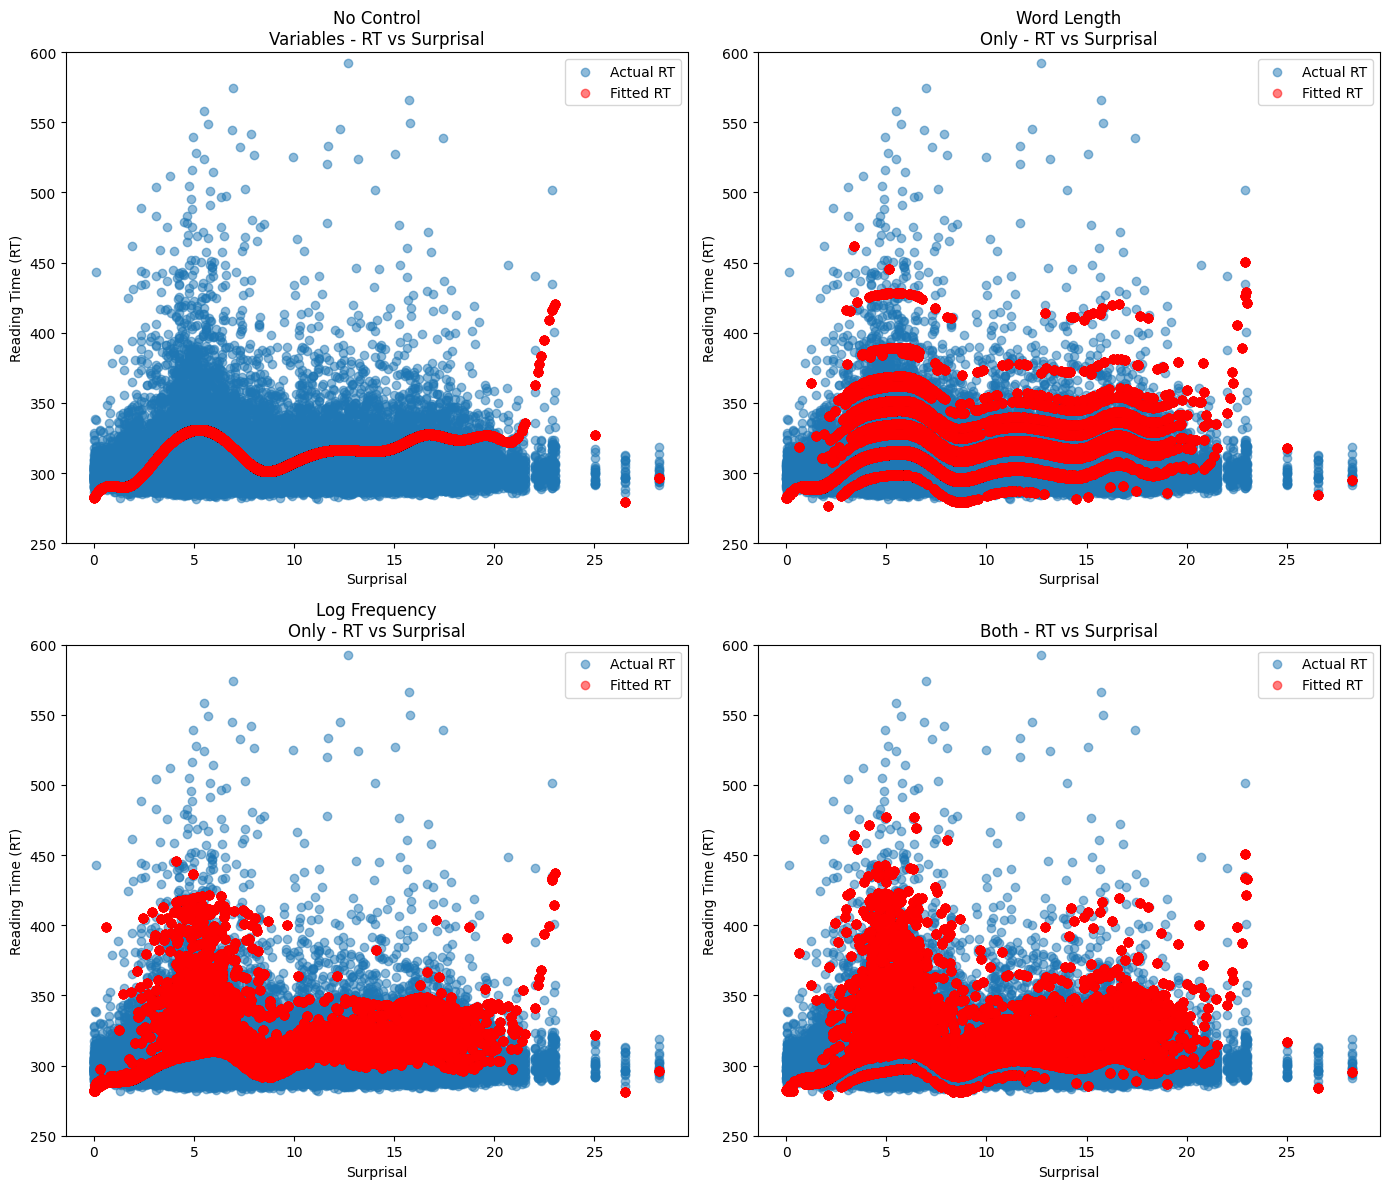

<Figure size 1200x1000 with 0 Axes>

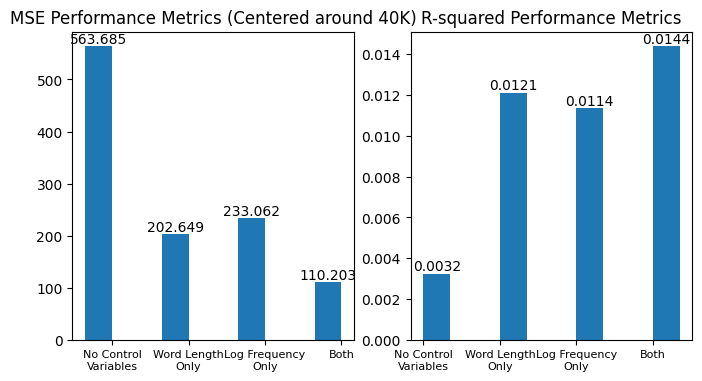

In [ ]:
gam_rnn_next = plot_with_gam(rnn_next, proc_word=True,plot_real_data=True)

We can see that in general there wasn't too much change to the conclusions we noticed in the original RNN data, however we can still notice some interesting changes.

First we can see that all the R-squared values are slightly higher here then in the first model - meaning the prediction works better for the spill over effect.

Another change can be spotted the MSE values.
All of them are lower by 500. the original values are off by 40K so that means a decreas of 1.25% which is rather small just like with the R-squared values on one hand, but out of 130K samples it is still very noticable.
More importantly, it follows the same logic - the GAM model predicted the RT of the next word slightly better.

That was expected since as we saw in class - usually the spill over effect is a bit more extreme making it easier to spot.

# NGRAM Surprisal values VS RTs
We want to see the difference between the models. So let's analyse the ngram models in the same manner.

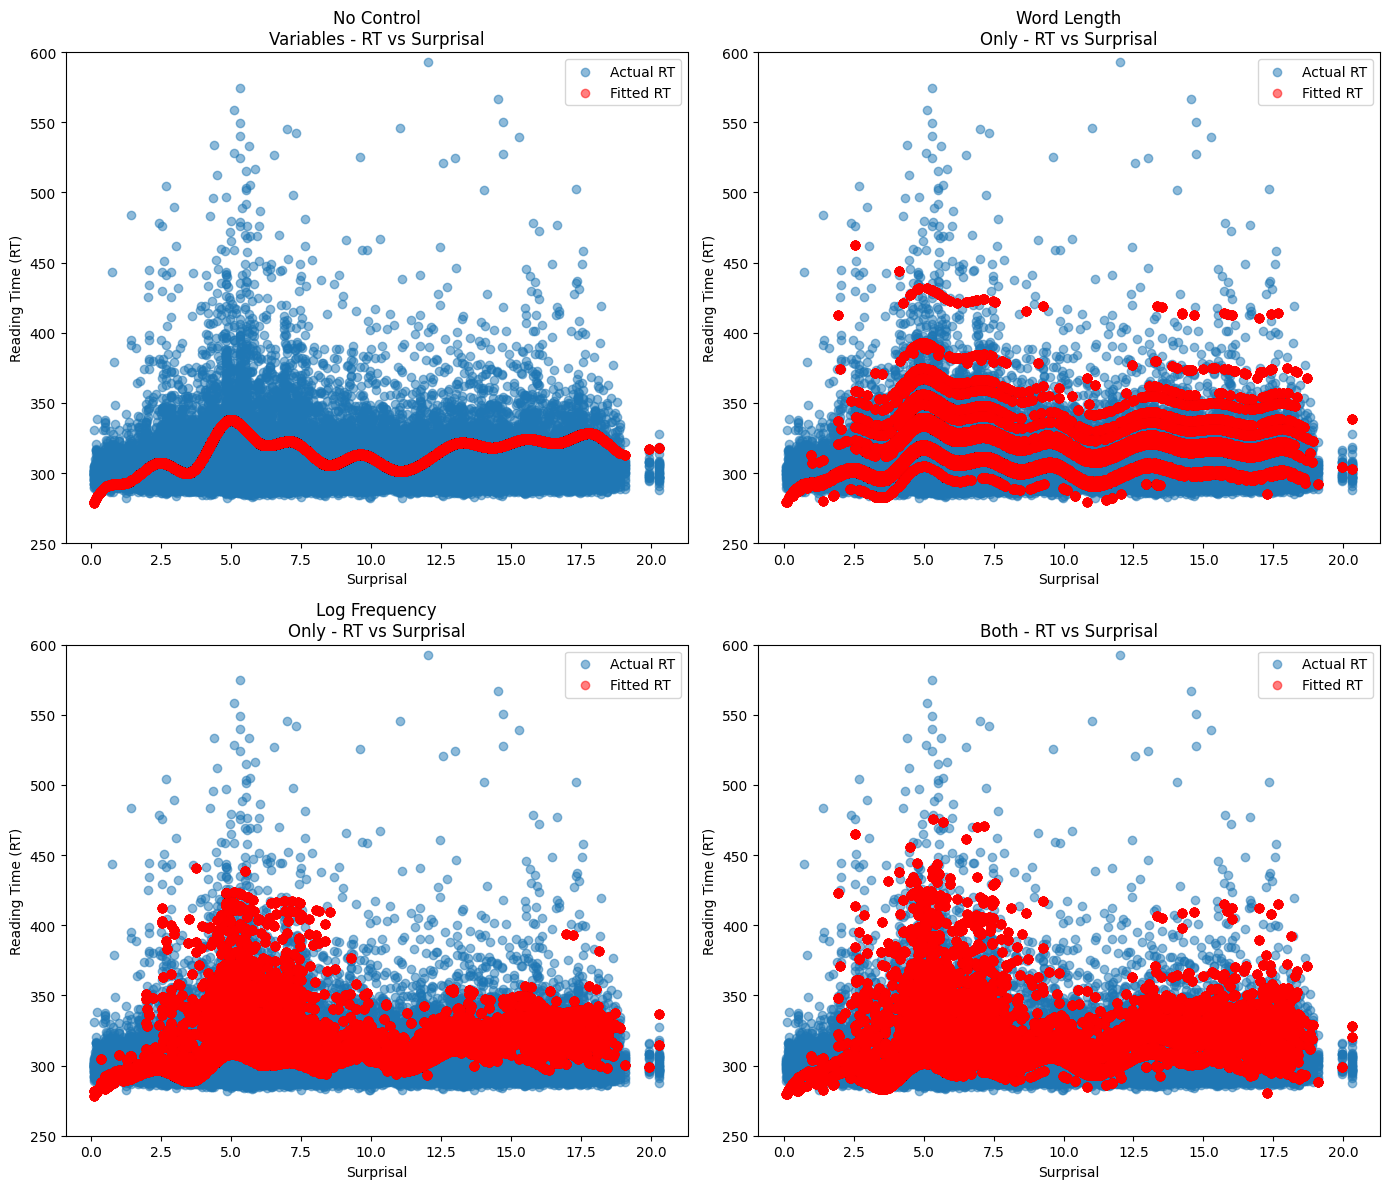

<Figure size 1200x1000 with 0 Axes>

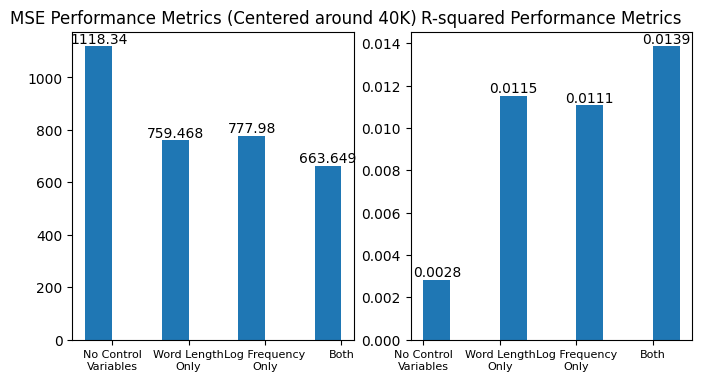

In [ ]:
gam_ngram = plot_with_gam(harmonized_ngram_df, proc_word=True,plot_real_data=True)

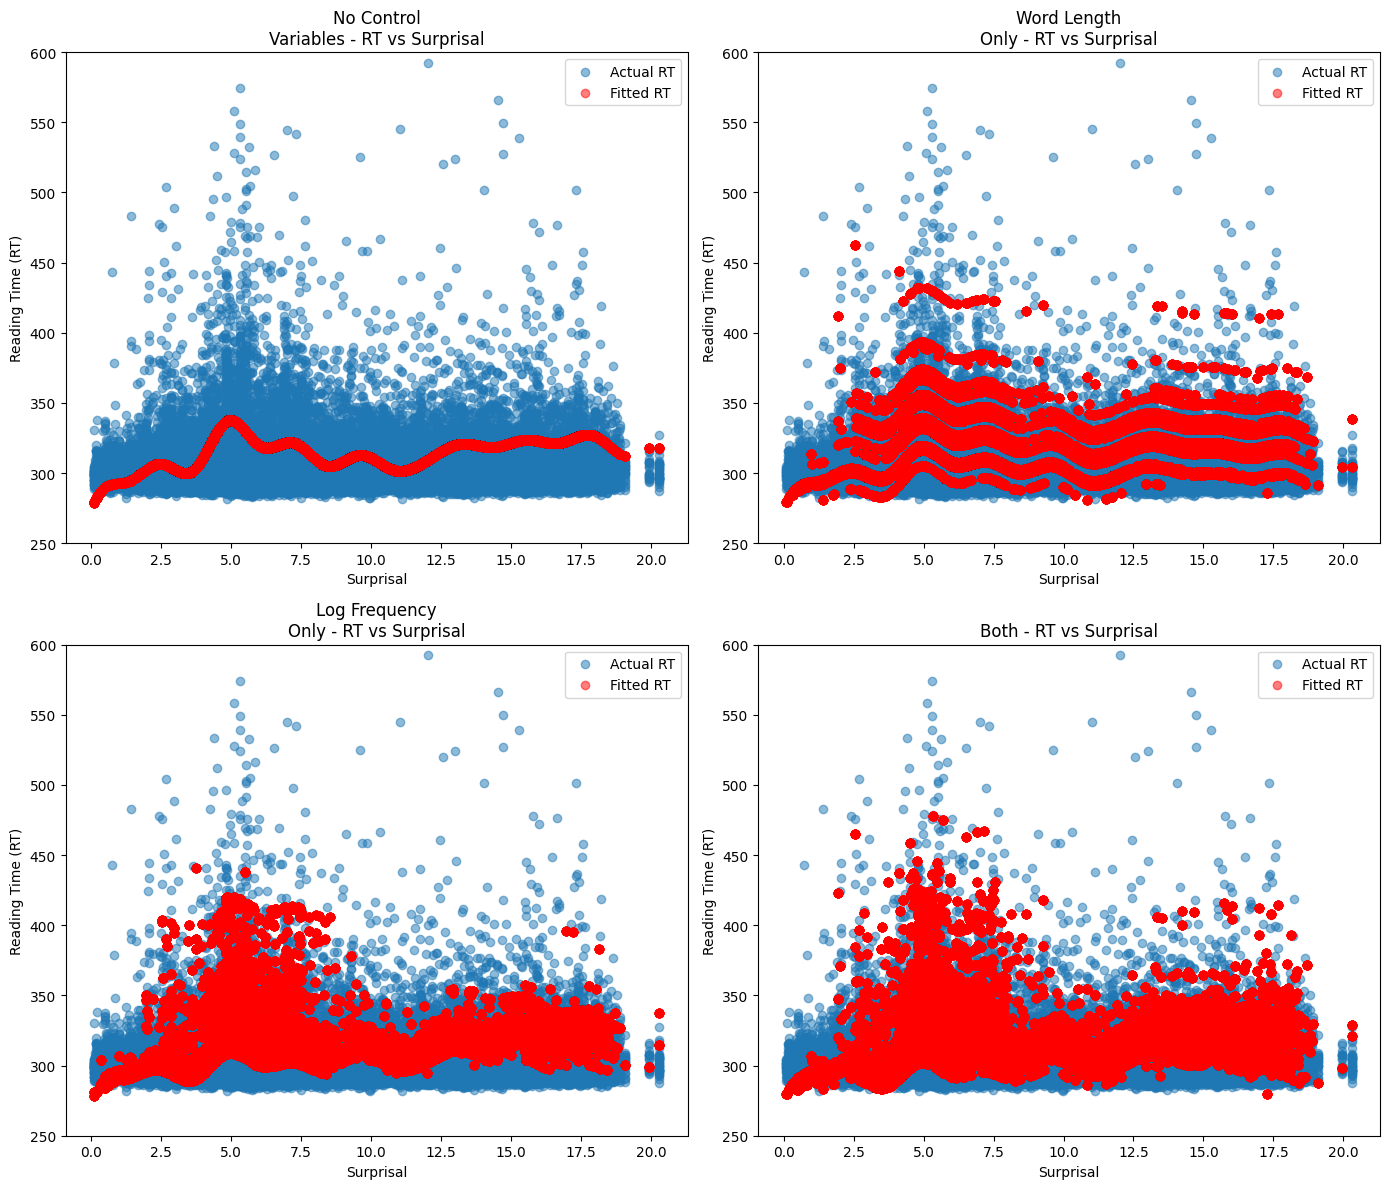

<Figure size 1200x1000 with 0 Axes>

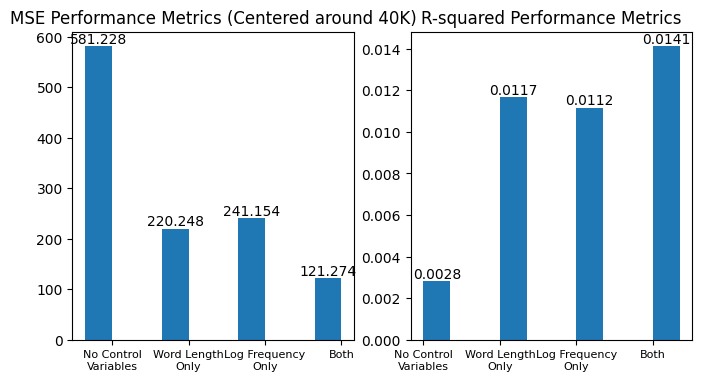

In [ ]:
gam_ngram_next = plot_with_gam(ngram_next, proc_word=True,plot_real_data=True)

### NGRAM results compare to the RNN model's suprisal values
As expected we can see the ngram model preforms poorly compare to the RNN model as we saw in the structured part.
It behaves similarly to the behavior we saw from the RNN model's values, but in general it preforms a bit worse.

Interesting things to notice here is that it underestimates the surprisal value as we saw in part 1 - and thus the model it also behaving as such.
It rarly uses a surprisal value of more then 20, meaning it can't handle anomalies very well - if it observes a very unlikly word it will be unable to explain the reader's behavior extermly enough which is very crucial since we see that in the RNN model, values above 20 are suddenly climbing very rapidly - probably by encountering very wierd words that make readers pause maybe even stop reading to try and understand (as we can see in the RNN case the values go up exponantially and our guess is the reaserchers didn't measure above a certain time, marking it as distractions).

# Conclusions of Task

## Explained Deviance and P-Values

In [ ]:
for gam_name,gam in zip(["gam_rnn", "gam_rnn_next", "gam_ngram", "gam_ngram_next"],[gam_rnn, gam_rnn_next, gam_ngram, gam_ngram_next]):
  print(f"####### {gam_name} #######")
  for k,v in gam.statistics_.items():
    if k not in ("n_samples","m_features",'pseudo_r2','p_values'):
      continue
    print(f"{k}:\t{v}")
  print("")

####### gam_rnn #######
n_samples:	129604
m_features:	3
pseudo_r2:	OrderedDict([('explained_deviance', 0.014110997366955202), ('McFadden', 0.9999999847462621), ('McFadden_adj', -3.1916084595629e-05)])
p_values:	[1.1102230246251565e-16, 1.1102230246251565e-16, 1.1102230246251565e-16, 1.1102230246251565e-16]

####### gam_rnn_next #######
n_samples:	125996
m_features:	3
pseudo_r2:	OrderedDict([('explained_deviance', 0.01438810589180839), ('McFadden', 0.9999999842137209), ('McFadden_adj', -3.285938493347018e-05)])
p_values:	[1.1102230246251565e-16, 1.1102230246251565e-16, 1.1102230246251565e-16, 1.1102230246251565e-16]

####### gam_ngram #######
n_samples:	129604
m_features:	3
pseudo_r2:	OrderedDict([('explained_deviance', 0.013854276017045697), ('McFadden', 0.9999999850320797), ('McFadden_adj', -3.239282507316865e-05)])
p_values:	[3.1356028884488296e-12, 1.1102230246251565e-16, 1.1102230246251565e-16, 1.1102230246251565e-16]

####### gam_ngram_next #######
n_samples:	125996
m_features:	3


We printed all the statistical values of the GAM models we computed.
First we can see that the p-values are very small - meaning that the variance that's explained by the variables we chose is significant.
That being said we can see that it fails to explain a lot of the variance we saw since the R-squared in all of the models is very small - but it makes sense, we saw this in the structured part as well, and the way the data was processed in order to train the model makes it very noisy to say the least.

## Coefficiants of Variables

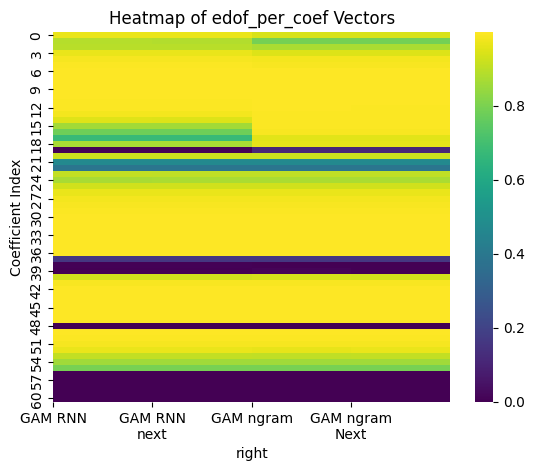

In [ ]:
# Assuming gam_rnn, gam_rnn_next, gam_ngram, gam_ngram_next are defined
gam_list = [gam_rnn, gam_rnn_next, gam_ngram, gam_ngram_next]

# Initialize a 61x4 matrix
mat = np.zeros((61, 4))

for i, gam in enumerate(gam_list):
    # Extract the 'edof_per_coef' vector and place it in the i-th column of the matrix
    mat[:, i] = gam.statistics_['edof_per_coef']

# Plot the heatmap
sns.heatmap(mat, cmap="viridis", annot=False)
plt.title("Heatmap of edof_per_coef Vectors")
plt.xlabel("GAM Models")
plt.ylabel("Coefficient Index")
plt.xticks(ticks=np.arange(4), labels=["GAM RNN", "GAM RNN\nnext", "GAM ngram", "GAM ngram\nNext"], rotation=0, ha='center')
plt.xlabel("right")
plt.show()

We can see the coefficients of each variable. We used the default 20 splines for each one and the last one is for the "error" variable of the model.
Recall the order is: 0-19 for "surprisal", 20-39 for "log-frequancy", 40-59 for "word length" and 60 for "error".
We'll claim for evidence about a linear connection between suprisal and reading time values:
- Argument for Linearity: The fact that most edof_per_coef values are near 1 suggests that the relationship between surprisal and RT is being modeled almost linearly in most splines.

 Coupled with a low explained_deviance, it implies that additional non-linear terms may not be substantially improving the model, supporting the argument for a linear relationship.
- Argument against Non-linearity: If the relationship were highly non-linear, we would expect higher edof_per_coef values and potentially better fit statistics (lower AIC/GCV), which isn't strongly evident in this case.

So in conclusion although the data we had is noisy and there's more to the RT that only surprisal values, word length and word frequancy, the do play a major part in the deviation of the reading time and we support the belife that their connection is mostly linear (can be modeled linearly).

# **Semi-Structured Part 2: Using Wikitext-2 as an Alternative dataset**

## Pre-processing Wikitext-2
The preprocessing routine is designed to clean and standardize the text, preparing it for further analysis.

First, titles surrounded by sequences of equal signs (=) are reformatted by removing the = signs, converting the titles into standard text. Next, the text is filtered to retain only specific characters, including letters, numbers, brackets, commas, semicolons, periods, apostrophes, and hyphens, while removing any extraneous characters to maintain consistency.

Possessive forms like "word 's" are then replaced with the placeholder <unk> to normalize these phrases throughout the text. Additionally, any empty lines are removed, ensuring that the text is compact and continuous. Finally, symbols such as @-@ and @,@ are replaced with the correct characters (- and , respectively) to ensure proper representation of hyphens and commas.

In [ ]:
import re
def preprocess_text(text):
    # Replace titles (remove '=' signs)
    text = re.sub(r'={2,}', '', text)

    # Remove spaces before commas, periods, colons, and semicolons
    text = re.sub(r'\s*([,.:;\)\'])', r'\1', text)
    # Remove spaces before commas, periods, colons, and semicolons
    text = re.sub(r'([\(]\s*)', r'\0', text)


    # Ensure there's a space after commas, periods, colons, and semicolons
    text = re.sub(r'([,.:;])(?=\S)', r'\1 ', text)

    # Handle "@-@" and "@,@" specifically
    text = re.sub(r'@-@', '-', text)
    text = re.sub(r'@,@', ',', text)

    # Replace instances of "word 's" with "<unk>"
    # 5. Handle numbers and units (e.g., "0 . 91 m" -> "0.91m")
    text = re.sub(r'(\d)\s*\.\s*(\d)', r'\1.\2', text)
    text = re.sub(r'(\d)\s*,\s*(\d)', r'\1,\2', text)

    # 6. Remove unwanted characters (keep only legal characters)
    text = re.sub(r'[^a-zA-Z0-9\[\]\(\),;:\.\s\'-\<\>]', '', text)

    # 7. Remove empty lines
    text = re.sub(r'\n\s*\n', '\n', text)

    # 8. Clean up multiple spaces
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    # text = re.sub(r"\b\w+\s'(?=s\b)", r"<unk>", text)
    # text = re.sub(r'\b\w*<unk>\w*\b', '<unk>', text)


    return text

In [ ]:
!mkdir -p /content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data
!cp rnn/data/wikitext-2/train.txt /content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/wikitext_train.txt
!cp rnn/data/wikitext-2/valid.txt /content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/wikitext_valid.txt
!cp rnn/data/wikitext-2/test.txt /content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/wikitext_test.txt
wikitext_paths =['/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/wikitext_train.txt',
                 '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/wikitext_valid.txt',
                 '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/wikitext_test.txt']
for p in wikitext_paths:
    # Read original text
    with open(p, 'r') as f:
        text = f.read()
    if 'wikitext_train' in p:
      brown_train = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/corpus_data/ptb_tok_train.txt'
      text += open(brown_train,'r').read()
    f.close()
    # Process text
    processed_text = preprocess_text(text)

    # Save processed text to a new file
    with open(p, 'w+', encoding='utf-8') as f:
        f.write(processed_text)


In [ ]:
!cd rnn && python main.py --cuda --model_file "/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/wikitext_model.pt" \
    --epochs 40 \
    --batch_size 200 \
    --vocab_file "/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/wikitext_vocab.txt" \
    --tied --data_dir "/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data" \
    --trainfname wikitext_train.txt --validfname wikitext_valid.txt


Libraries loaded
Traceback (most recent call last):
  File "/content/rnn/main.py", line 566, in <module>
    train()
  File "/content/rnn/main.py", line 529, in train
    output, hidden_batch[sub_batch_ix] = model(batch_data[:,sub_batch_start:sub_batch_end], hidden_batch[sub_batch_ix])
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/content/rnn/model.py", line 88, in forward
    decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_ca

In [ ]:
checkpoint_to_use = "/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/wikitext_model.pt"
GDRIVE_DIR="/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data"
!mkdir -p "$GDRIVE_DIR"
!mkdir -p "$GDRIVE_DIR/corpus_data"
!cp rnn/data/brown.txt /content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/

## **Compute Model Surprisals Using Wikitext2 Trained RNN Model**

In [ ]:
checkpoint_to_use = "/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/wikitext_model.pt"  # Path to your trained model
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/wikitext_vocab.txt" \
    --data_dir '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data' \
    --testfname 'brown.txt' --test --words --nopp > "/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/rnn_wikitext2_surprisals.tsv"


Libraries loaded
Using beamsize: 74213


In [ ]:
# Load the surprisals generated Wikitext-2 trained model
rnn_wikitext2_surprisals = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/rnn_wikitext2_surprisals.tsv', sep=' ')
#Use the harmonize function to align the RNN surprisal values with the SPRT data:
harmonized_rnn_wikitext2_df = harmonize(sprt, rnn_wikitext2_surprisals, is_rnn=True)
harmonized_rnn_wikitext2_df.to_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/harmonized_rnn_wikitext2_df.csv')
harmonized_rnn_wikitext2_df

,word,code,subject,text_id,text_pos,word_in_exp,time,wlen,surprisal,entropy,entred
0,In,17000,s001,0,0,2285,399.90,2,4.829099,9.989824,0.0
1,In,17000,s028,0,0,2503,290.32,2,4.829099,9.989824,0.0
2,In,17000,s014,0,0,1394,501.59,2,4.829099,9.989824,0.0
3,In,17000,s021,0,0,2525,210.93,2,4.829099,9.989824,0.0
4,In,17000,s010,0,0,579,862.35,2,4.829099,9.989824,0.0
...,...,...,...,...,...,...,...,...,...,...,...
129731,captain.,35763,s021,12,763,1430,425.18,8,17.622387,10.520931,0.0
129732,captain.,35763,s030,12,763,1489,383.32,8,17.622387,10.520931,0.0
129733,captain.,35763,s007,12,763,3426,506.40,8,17.622387,10.520931,0.0
129734,captain.,35763,s004,12,763,3528,669.29,8,17.622387,10.520931,0.0


## Compute Model Surprisals Using Wikitext2 Trained 5-gram Model

In [ ]:
wikitext_train_path = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/wikitext_train.txt'

# Load the Wikitext-2 training data
with open(wikitext_train_path, 'r') as file:
    wikitext_train_text = file.read()

# Tokenize the text
tokens = word_tokenize(wikitext_train_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from copy import deepcopy
# Initialize a defaultdict to store the 5-gram model
fivegram_model = defaultdict(lambda: defaultdict(int))

# Create 5-grams from the tokenized text
fivegrams = list(ngrams(tokens, 5))

# Count frequency of each 5-gram
for fivegram in fivegrams:
    prefix = tuple(fivegram[:-1])  # The first 4 words as context
    next_word = fivegram[-1]  # The fifth word as the predicted word
    fivegram_model[prefix][next_word] += 1

# Convert counts to probabilities
for prefix, next_words in fivegram_model.items():
    total_count = float(sum(next_words.values()))
    for word in next_words:
        fivegram_model[prefix][word] /= total_count

# Initialize an empty list to store the new 5-gram surprisals
fivegram_surprisal_values = []

# Iterate over the DataFrame rows and calculate surprisal
current_sentence_id = None

for i, row in ngram_surprisals.iterrows():
    token = row['token']
    sentence_id = row['sentence_id']

    # Reset context at the start of a new sentence
    if sentence_id != current_sentence_id:
        current_context = []
        current_sentence_id = sentence_id

    # Calculate surprisal using the 5-gram model
    if len(current_context) >= 4:  # Only calculate if there are 4 preceding words
        context_tuple = tuple(current_context[-4:])  # The previous 4 words as context
        prob = fivegram_model[context_tuple].get(token, 1e-10)
    else:
        prob = 1e-10  # Assign low probability if the context is too short

    surprisal = -np.log2(prob)
    fivegram_surprisal_values.append(surprisal)

    # Update the context
    current_context.append(token)

# Create a new DataFrame for the 5-gram surprisals
wikitext_fivegram_surprisals = deepcopy(ngram_surprisals)
wikitext_fivegram_surprisals['surprisal'] = fivegram_surprisal_values

wikitext_fivegram_surprisals

,sentence_id,token_id,token,surprisal
0,1,1,In,33.219281
1,1,2,<unk>,33.219281
2,1,3,County,33.219281
3,1,4,<unk>,33.219281
4,1,5,near,33.219281
...,...,...,...,...
7693,464,17,a,33.219281
7694,464,18,leader,33.219281
7695,464,19,and,33.219281
7696,464,20,<unk>,33.219281


Almost all words got a surprisal value of 33.219, this is likely due to the domain mismatch between the training and testing data, the 5-gram model was trained on Wikitext2, which has a different vocabulary and sentence structure compared to Penn Treebank. This leads to many out of vocabulary tokens and unseen ngrams when applying the model to the Penn Treebank data. As a result, the model assigns low probabilities to these unfamiliar sequences, resulting in high surprisal values. also the sparsity inherent in a 5-gram model make this issue worse as it requires specific sequences that are rare or absent in the new data.

Since the 5-gram model is not very informative here, we decided to switch to a bigram model for calculating surprisals on Penn Treebank because the 5-gram model consistently produced high surprisal values, likely due to domain mismatch and the sparsity of specific ngram sequences. The bigram model being less reliant on longer contexts, should provide more reliable estimates here.

## Compute Model Surprisals Using Wikitext2 Trained Bigram Model

In [ ]:
# Initialize a defaultdict to store the 2-gram model
bigram_model = defaultdict(lambda: defaultdict(int))

# Create 2-grams from the tokenized text
bigrams = list(ngrams(tokens, 2))

# Count frequency of each 2-gram
for bigram in bigrams:
    prefix = bigram[0]  # The first word as context
    next_word = bigram[1]  # The second word as the predicted word
    bigram_model[prefix][next_word] += 1

# Convert counts to probabilities
for prefix, next_words in bigram_model.items():
    total_count = float(sum(next_words.values()))
    for word in next_words:
        bigram_model[prefix][word] /= total_count

# Initialize an empty list to store the new 2-gram surprisals
bigram_surprisal_values = []

# Iterate over the DataFrame rows and calculate surprisal
current_sentence_id = None

for i, row in ngram_surprisals.iterrows():
    token = row['token']
    sentence_id = row['sentence_id']

    # Reset context at the start of a new sentence
    if sentence_id != current_sentence_id:
        current_context = []
        current_sentence_id = sentence_id

    # Calculate surprisal using the 2-gram model
    if current_context:  # Only calculate if there's a preceding word
        previous_word = current_context[-1]  # The previous word
        prob = bigram_model[previous_word].get(token, 1e-10)
    else:
        prob = 1e-10  # Assign low probability if no context

    surprisal = -np.log2(prob)
    bigram_surprisal_values.append(surprisal)

    # Update the context
    current_context.append(token)

# Create a new DataFrame for the 2-gram surprisals
wikitext_bigram_surprisals = ngram_surprisals.copy()
wikitext_bigram_surprisals['surprisal'] = bigram_surprisal_values

wikitext_bigram_surprisals

,sentence_id,token_id,token,surprisal
0,1,1,In,33.219281
1,1,2,<unk>,33.219281
2,1,3,County,33.219281
3,1,4,<unk>,33.219281
4,1,5,near,33.219281
...,...,...,...,...
7693,464,17,a,2.508485
7694,464,18,leader,12.007647
7695,464,19,and,5.452859
7696,464,20,<unk>,33.219281


In [ ]:
harmonized_bigram_df = harmonize(sprt, wikitext_bigram_surprisals, is_rnn=False)
harmonized_bigram_df.to_csv(f'{GDRIVE_DIR}/harmonized_bigram_df.csv')
harmonized_fivegram_df = harmonize(sprt, wikitext_fivegram_surprisals, is_rnn=False)
harmonized_fivegram_df.to_csv(f'{GDRIVE_DIR}/harmonized_fivegram_df.csv')

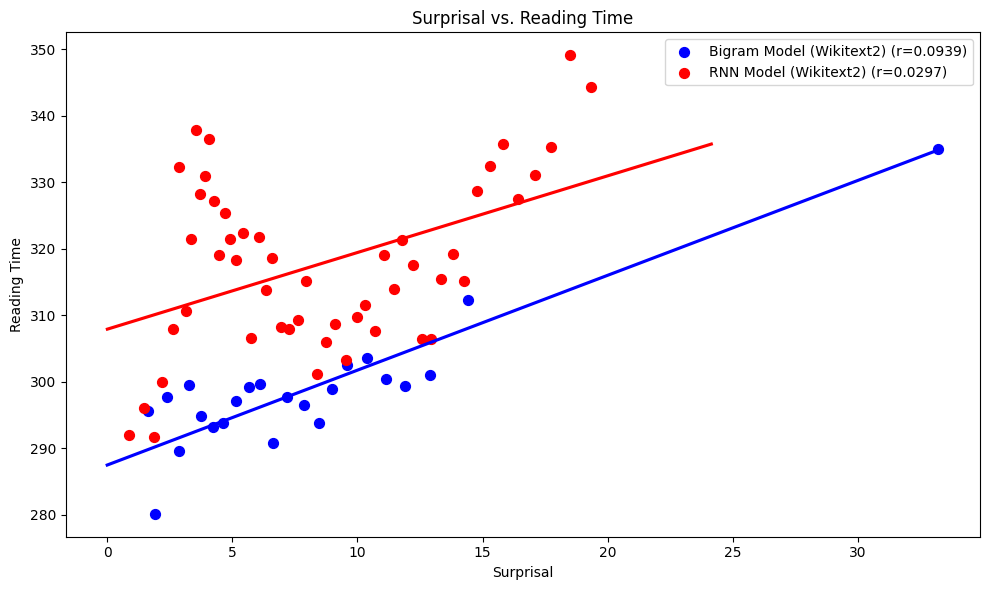

In [ ]:
# Load data
harmonized_bigram_df = pd.read_csv(f'{GDRIVE_DIR}/harmonized_bigram_df.csv')
harmonized_fivegram_df = pd.read_csv(f'{GDRIVE_DIR}/harmonized_fivegram_df.csv')
harmonized_rnn = pd.read_csv(f"{GDRIVE_DIR}/wikitext_data/harmonized_rnn_wikitext2_df.csv")

# Calculate correlation coefficients
corr_2gram, _ = pearsonr(harmonized_bigram_df['surprisal'], harmonized_bigram_df['time'])
corr_5gram, _ = pearsonr(harmonized_fivegram_df['surprisal'], harmonized_fivegram_df['time'])
corr_rnn, _ = pearsonr(harmonized_rnn['surprisal'], harmonized_rnn['time'])

# Plot
plt.figure(figsize=(10, 6))
sns.regplot(x="surprisal", y="time", data=harmonized_bigram_df, x_bins=50, color='blue', ci=0, label=f'Bigram Model (Wikitext2) (r={corr_2gram:.4f})')
# sns.regplot(x="surprisal", y="time", data=harmonized_fivegram_df, x_bins=50, color='green', ci=0, label=f'5-gram Model (Wikitext2) (r={corr_5gram:.4f})')
sns.regplot(x="surprisal", y="time", data=harmonized_rnn, x_bins=50, color='red', ci=0, label=f'RNN Model (Wikitext2) (r={corr_rnn:.4f})')

# Add titles and labels
plt.title('Surprisal vs. Reading Time')
plt.xlabel('Surprisal')
plt.ylabel('Reading Time')

# Add a legend
plt.legend()

plt.tight_layout()
plt.show()


The results show that the ngram and RNN model perform poorly on the Penn Treebank dataset, with very low correlations between surprisal and reading time (r ≈ 0.004-0.008), this suggests that both models particularly the 5-gram model, struggle with generalization due to domain mismatch and n-gram sparsity. In contrast, on the Wikitext-2 dataset where both the bigram and RNN models were trained, the correlations improve slightly, especially for the bigram model (r ≈ 0.093), indicating a better (though still weak), alignment with reading times. The bigram model stronger performance may reflect its robustness in handling simpler more frequent patterns, whereas the RNN, while more complex, still shows weaker generalization likely due to its reliance on more specific contextual information.

# **Open-Ended Task**

## **Train an LSTM model on Wikitext-2**

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        lstm_out, _ = self.lstm(embedded)
        output = self.fc(lstm_out)
        return output

class WikitextDataset(Dataset):
  def __init__(self, tokens, seq_length=50, stride=50):
      self.seq_length = seq_length
      self.stride = stride
      self.tokens = tokens.squeeze(0)  # Remove the batch dimension if necessary

  def __len__(self):
      return (self.tokens.size(0) - self.seq_length) // self.stride

  def __getitem__(self, idx):
      start_idx = idx * self.stride
      end_idx = start_idx + self.seq_length
      return (self.tokens[start_idx:end_idx],
              self.tokens[start_idx+1:end_idx+1])

class PennTreebankDataset(Dataset):
    def __init__(self, tokens, seq_length=50, stride=50):
        self.seq_length = seq_length
        self.stride = stride
        self.tokens = tokens.squeeze(0)  # Remove the batch dimension if necessary

    def __len__(self):
        return (self.tokens.size(0) - self.seq_length) // self.stride

    def __getitem__(self, idx):
        start_idx = idx * self.stride
        end_idx = start_idx + self.seq_length
        return (self.tokens[start_idx:end_idx],
                self.tokens[start_idx+1:end_idx+1])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Load and Tokenize the Data
wikitext_train_path = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/wikitext_train.txt'
wikitext_valid_path = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/wikitext_valid.txt'

# Initialize the tokenizer (BERT tokenizer as an example)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Load and tokenize the training data
with open(wikitext_train_path, 'r', encoding='utf-8') as f:
    train_text = f.read()

train_tokens = tokenizer(train_text, return_tensors='pt', padding=False, truncation=False)['input_ids']
print(f"Number of tokens after tokenization (train): {train_tokens.size(1)}")

# Load and tokenize the validation data
with open(wikitext_valid_path, 'r', encoding='utf-8') as f:
    valid_text = f.read()

valid_tokens = tokenizer(valid_text, return_tensors='pt', padding=False, truncation=False)['input_ids']
print(f"Number of tokens after tokenization (valid): {valid_tokens.size(1)}")


# Create the datasets and dataloaders
train_dataset = WikitextDataset(train_tokens, seq_length=100, stride=100)
valid_dataset = WikitextDataset(valid_tokens, seq_length=100, stride=100)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=200, shuffle=False)

print(f"New size of train dataset: {len(train_dataset)}")
print(f"New size of valid dataset: {len(valid_dataset)}")



# Hyperparameters
vocab_size = tokenizer.vocab_size
embedding_dim = 300
hidden_dim = 256
output_dim = vocab_size
n_layers = 2
dropout = 0.3

# Initialize the model
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout).to(device)


criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=0.001)




Token indices sequence length is longer than the specified maximum sequence length for this model (3394238 > 512). Running this sequence through the model will result in indexing errors


Number of tokens after tokenization (train): 3394238
Number of tokens after tokenization (valid): 247513
New size of train dataset: 33941
New size of valid dataset: 2474


In [ ]:
n_epochs = 20
model.train()

for epoch in range(n_epochs):
    epoch_loss = 0
    model.train()  # Set the model to training mode
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(-1, outputs.shape[-1])
        targets = targets.view(-1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {avg_epoch_loss:.4f}")

    # Validation step
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc=f"Validating Epoch {epoch+1}/{n_epochs}"):
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            outputs = outputs.view(-1, outputs.shape[-1])
            targets = targets.view(-1)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(valid_loader)
    print(f"Epoch {epoch+1}/{n_epochs}, Validation Loss: {avg_val_loss:.4f}")

# Save the Model
model_save_path = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/lstm_model_with_validation.pt'
torch.save(model.state_dict(), model_save_path)
print(f"LSTM model saved to {model_save_path}")

Epoch 1/20: 100%|██████████| 170/170 [01:07<00:00,  2.52it/s]


Epoch 1/20, Training Loss: 7.0670


Validating Epoch 1/20: 100%|██████████| 13/13 [00:01<00:00,  7.19it/s]


Epoch 1/20, Validation Loss: 6.0762


Epoch 2/20: 100%|██████████| 170/170 [01:09<00:00,  2.46it/s]


Epoch 2/20, Training Loss: 6.6273


Validating Epoch 2/20: 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


Epoch 2/20, Validation Loss: 5.8275


Epoch 3/20: 100%|██████████| 170/170 [01:10<00:00,  2.42it/s]


Epoch 3/20, Training Loss: 6.3980


Validating Epoch 3/20: 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]


Epoch 3/20, Validation Loss: 5.6010


Epoch 4/20: 100%|██████████| 170/170 [01:11<00:00,  2.38it/s]


Epoch 4/20, Training Loss: 6.2188


Validating Epoch 4/20: 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]


Epoch 4/20, Validation Loss: 5.4843


Epoch 5/20: 100%|██████████| 170/170 [01:11<00:00,  2.38it/s]


Epoch 5/20, Training Loss: 6.0994


Validating Epoch 5/20: 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]


Epoch 5/20, Validation Loss: 5.3824


Epoch 6/20: 100%|██████████| 170/170 [01:11<00:00,  2.36it/s]


Epoch 6/20, Training Loss: 5.9961


Validating Epoch 6/20: 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]


Epoch 6/20, Validation Loss: 5.2982


Epoch 7/20: 100%|██████████| 170/170 [01:12<00:00,  2.36it/s]


Epoch 7/20, Training Loss: 5.8968


Validating Epoch 7/20: 100%|██████████| 13/13 [00:01<00:00,  6.55it/s]


Epoch 7/20, Validation Loss: 5.2234


Epoch 8/20: 100%|██████████| 170/170 [01:12<00:00,  2.35it/s]


Epoch 8/20, Training Loss: 5.8051


Validating Epoch 8/20: 100%|██████████| 13/13 [00:01<00:00,  6.77it/s]


Epoch 8/20, Validation Loss: 5.1561


Epoch 9/20: 100%|██████████| 170/170 [01:12<00:00,  2.36it/s]


Epoch 9/20, Training Loss: 5.7244


Validating Epoch 9/20: 100%|██████████| 13/13 [00:01<00:00,  6.85it/s]


Epoch 9/20, Validation Loss: 5.0970


Epoch 10/20: 100%|██████████| 170/170 [01:12<00:00,  2.36it/s]


Epoch 10/20, Training Loss: 5.6510


Validating Epoch 10/20: 100%|██████████| 13/13 [00:01<00:00,  6.85it/s]


Epoch 10/20, Validation Loss: 5.0437


Epoch 11/20: 100%|██████████| 170/170 [01:12<00:00,  2.36it/s]


Epoch 11/20, Training Loss: 5.5837


Validating Epoch 11/20: 100%|██████████| 13/13 [00:01<00:00,  6.82it/s]


Epoch 11/20, Validation Loss: 4.9891


Epoch 12/20: 100%|██████████| 170/170 [01:12<00:00,  2.36it/s]


Epoch 12/20, Training Loss: 5.5205


Validating Epoch 12/20: 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]


Epoch 12/20, Validation Loss: 4.9547


Epoch 13/20: 100%|██████████| 170/170 [01:12<00:00,  2.36it/s]


Epoch 13/20, Training Loss: 5.4615


Validating Epoch 13/20: 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]


Epoch 13/20, Validation Loss: 4.9133


Epoch 14/20: 100%|██████████| 170/170 [01:12<00:00,  2.35it/s]


Epoch 14/20, Training Loss: 5.4002


Validating Epoch 14/20: 100%|██████████| 13/13 [00:01<00:00,  6.77it/s]


Epoch 14/20, Validation Loss: 4.8769


Epoch 15/20: 100%|██████████| 170/170 [01:12<00:00,  2.36it/s]


Epoch 15/20, Training Loss: 5.3376


Validating Epoch 15/20: 100%|██████████| 13/13 [00:01<00:00,  6.77it/s]


Epoch 15/20, Validation Loss: 4.8335


Epoch 16/20: 100%|██████████| 170/170 [01:12<00:00,  2.36it/s]


Epoch 16/20, Training Loss: 5.2813


Validating Epoch 16/20: 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]


Epoch 16/20, Validation Loss: 4.8046


Epoch 17/20: 100%|██████████| 170/170 [01:12<00:00,  2.36it/s]


Epoch 17/20, Training Loss: 5.2306


Validating Epoch 17/20: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s]


Epoch 17/20, Validation Loss: 4.7794


Epoch 18/20: 100%|██████████| 170/170 [01:12<00:00,  2.35it/s]


Epoch 18/20, Training Loss: 5.1859


Validating Epoch 18/20: 100%|██████████| 13/13 [00:01<00:00,  6.76it/s]


Epoch 18/20, Validation Loss: 4.7486


Epoch 19/20: 100%|██████████| 170/170 [01:12<00:00,  2.35it/s]


Epoch 19/20, Training Loss: 5.1424


Validating Epoch 19/20: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]


Epoch 19/20, Validation Loss: 4.7258


Epoch 20/20: 100%|██████████| 170/170 [01:12<00:00,  2.35it/s]


Epoch 20/20, Training Loss: 5.1021


Validating Epoch 20/20: 100%|██████████| 13/13 [00:01<00:00,  6.76it/s]


Epoch 20/20, Validation Loss: 4.6970
LSTM model saved to /content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/lstm_model_with_validation.pt


In [ ]:
def compute_surprisal_lstm(model, tokenizer, context, target_token):
    # Tokenize the context
    input_ids = tokenizer(context, return_tensors='pt', add_special_tokens=False)['input_ids']
    input_ids = input_ids.to(device)

    # Get the model's output
    with torch.no_grad():
        output = model(input_ids)

    # Compute the probability of the target token
    target_token_id = tokenizer.convert_tokens_to_ids(target_token)
    token_probs = torch.softmax(output[:, -1, :], dim=-1)
    target_prob = token_probs[0, target_token_id].item()

    # Compute surprisal
    surprisal = -torch.log2(torch.tensor(target_prob)).item()
    return surprisal


In [ ]:
vocab_size = tokenizer.vocab_size
embedding_dim = 300
hidden_dim = 256
output_dim = vocab_size
n_layers = 2
dropout = 0.3

In [ ]:
# Function to compute surprisal using the LSTM model
def compute_surprisal_lstm(model, tokenizer, current_context, target_token):
    # Tokenize the context
    input_ids = tokenizer(current_context, return_tensors='pt', add_special_tokens=False)['input_ids']
    input_ids = input_ids.to(device)

    # Get the model's output
    with torch.no_grad():
        output = model(input_ids)

    # Compute the probability of the target token
    target_token_id = tokenizer.convert_tokens_to_ids(target_token)
    token_probs = torch.softmax(output[:, -1, :], dim=-1)
    target_prob = token_probs[0, target_token_id].item()

    # Compute surprisal
    surprisal = -np.log2(target_prob)
    return surprisal


# Load the trained LSTM model
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
model_save_path = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/lstm_model_with_validation.pt'
model.load_state_dict(torch.load(model_save_path,map_location=device))
model.eval()  # Set the model to evaluation mode

# Load the ngram_surprisals dataset
ngram_surprisals = ngram_surprisals.copy()

# Initialize an empty list to store the LSTM surprisals
lstm_surprisal_values = []

# Iterate over each row in the ngram_surprisals dataset and calculate surprisal using the LSTM model
current_sentence_id = None
current_context = ""

for i, row in ngram_surprisals.iterrows():
    token = row['token']
    sentence_id = row['sentence_id']

    # Reset context at the start of a new sentence
    if sentence_id != current_sentence_id:
        current_context = ""
        current_sentence_id = sentence_id

    # Calculate surprisal using the LSTM model
    if current_context:  # Only calculate if there's a preceding context
        surprisal = compute_surprisal_lstm(model, tokenizer, current_context, token)
    else:
        surprisal = -np.log2(1e-10)  # Assign high surprisal if no context (log2(1e-10))

    lstm_surprisal_values.append(surprisal)

    # Update the context by adding the current token
    current_context += token + " "

# Create a new DataFrame for the LSTM-based surprisals
lstm_surprisals = ngram_surprisals.copy()
lstm_surprisals['surprisal'] = lstm_surprisal_values

# Save the new DataFrame with LSTM surprisals
lstm_surprisals.to_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/lstm_surprisals.csv', index=False)

print("LSTM-based surprisal calculation completed and saved.")


<ipython-input-45-c8abe66f568e>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path,map_location=device))


LSTM-based surprisal calculation completed and saved.


In [ ]:
lstm_surprisals

,sentence_id,token_id,token,surprisal
0,1,1,In,33.219281
1,1,2,<unk>,27.725456
2,1,3,County,27.972803
3,1,4,<unk>,28.603777
4,1,5,near,10.574355
...,...,...,...,...
7693,464,17,a,1.666222
7694,464,18,leader,12.076872
7695,464,19,and,4.549847
7696,464,20,<unk>,27.029117


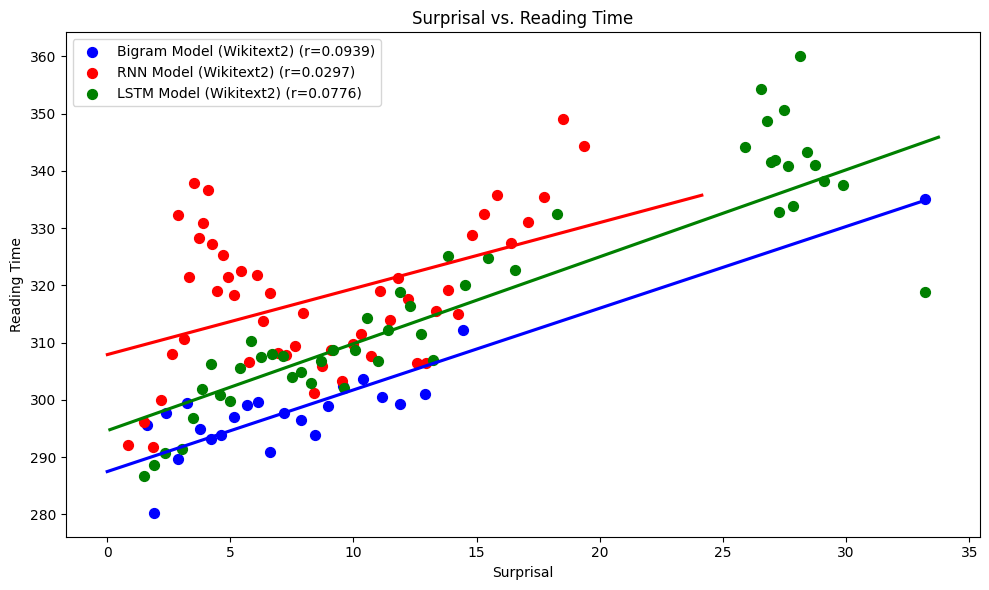

In [ ]:
lstm_surprisals = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/wikitext_data/lstm_surprisals.csv')
harmonized_lstm=harmonize(sprt, lstm_surprisals, is_rnn=False)
# Calculate correlation coefficients
corr_ngram, _ = pearsonr(harmonized_bigram_df['surprisal'], harmonized_bigram_df['time'])
corr_rnn, _ = pearsonr(harmonized_rnn['surprisal'], harmonized_rnn['time'])
corr_lstm, _ = pearsonr(harmonized_lstm['surprisal'], harmonized_lstm['time'])

# Plot
plt.figure(figsize=(10, 6))

sns.regplot(x="surprisal", y="time", data=harmonized_bigram_df, x_bins=50, color='blue', ci=0, label=f'Bigram Model (Wikitext2) (r={corr_ngram:.4f})')
sns.regplot(x="surprisal", y="time", data=harmonized_rnn, x_bins=50, color='red', ci=0, label=f'RNN Model (Wikitext2) (r={corr_rnn:.4f})')
sns.regplot(x="surprisal", y="time", data=harmonized_lstm, x_bins=50, color='green', ci=0, label=f'LSTM Model (Wikitext2) (r={corr_lstm:.4f})')

# Add titles and labels
plt.title('Surprisal vs. Reading Time')
plt.xlabel('Surprisal')
plt.ylabel('Reading Time')

# Add a legend
plt.legend()

plt.tight_layout()
plt.show()


## Merge all the surprisal values (Trained on Wikitext)

In [ ]:
cols=['word','code','subject','surprisal','time']
bigram_surp_df=harmonized_bigram_df.copy()[cols]
bigram_surp_df.rename(columns={'surprisal': 'bigram_wikitext_surprisal'}, inplace=True)

rnn_surp_df=harmonized_rnn.copy()[cols]
rnn_surp_df.rename(columns={'surprisal': 'rnn_wikitext_surprisal'}, inplace=True)

lstm_surp_df=harmonized_lstm.copy()[cols]
lstm_surp_df.rename(columns={'surprisal': 'lstm_wikitext_surprisal'}, inplace=True)

rnn_codes=rnn_surp_df.copy()[['code','rnn_wikitext_surprisal']].drop_duplicates()
bigram_codes=bigram_surp_df.copy()[['code','bigram_wikitext_surprisal']].drop_duplicates()
lstm_codes=lstm_surp_df.copy()[['code','lstm_wikitext_surprisal']].drop_duplicates()

merged_wikitext_surp_df = pd.merge(rnn_codes, bigram_codes, on='code', how='inner')
merged_wikitext_surp_df = pd.merge(merged_wikitext_surp_df, lstm_codes, on='code', how='inner')
merged_wikitext_surp_df

,code,rnn_wikitext_surprisal,bigram_wikitext_surprisal,lstm_wikitext_surprisal
0,17000,4.829099,33.219281,33.219281
1,17001,6.136724,33.219281,27.725456
2,17002,14.196862,33.219281,27.972803
3,17003,19.484367,33.219281,28.603777
4,17004,14.041258,33.219281,10.574355
...,...,...,...,...
6797,35759,7.309458,8.495855,8.130379
6798,35760,1.898763,2.508485,1.666222
6799,35761,11.218088,12.007647,12.076872
6800,35762,3.954449,5.452859,4.549847


## **Training the models on Treebank**

In [ ]:
# Load the Penn Treebank training data
ptb_train_path = "/content/gdrive/My Drive/096222_project_surprisals_and_rts/corpus_data/ptb_tok_train.txt"
with open(ptb_train_path, 'r', encoding='utf-8') as f:
    ptb_train_text = f.read()

# Tokenize the text
tokens = nltk.word_tokenize(ptb_train_text)

# Initialize a defaultdict to store the bigram model
bigram_model = defaultdict(lambda: defaultdict(int))

# Create bigrams from the tokenized text
bigrams = list(ngrams(tokens, 2))

# Count frequency of each bigram
for bigram in bigrams:
    prefix = bigram[0]  # The first word as context
    next_word = bigram[1]  # The second word as the predicted word
    bigram_model[prefix][next_word] += 1

# Convert counts to probabilities
for prefix, next_words in bigram_model.items():
    total_count = float(sum(next_words.values()))
    for word in next_words:
        bigram_model[prefix][word] /= total_count




In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and tokenize the Penn Treebank training data
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Tokenize the training data
ptb_train_tokens = tokenizer(ptb_train_text, return_tensors='pt', padding=False, truncation=False)['input_ids']

#Create a Custom Dataset Class


# Create the dataset and DataLoader
train_dataset = PennTreebankDataset(ptb_train_tokens, seq_length=100, stride=100)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)


# Hyperparameters
vocab_size = tokenizer.vocab_size
embedding_dim = 300
hidden_dim = 256
output_dim = vocab_size
n_layers = 2
dropout = 0.3

# Initialize the model
lstm_model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout).to(device)

#  Define Loss and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Train the LSTM Model
n_epochs = 20
lstm_model.train()

for epoch in range(n_epochs):
    epoch_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = lstm_model(inputs)
        outputs = outputs.view(-1, outputs.shape[-1])
        targets = targets.view(-1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_epoch_loss:.4f}")

# Save the Model
lstm_model_save_path = '/content/gdrive/MyDrive/ptb_lstm_model.pt'
torch.save(lstm_model.state_dict(), lstm_model_save_path)
print(f"LSTM model saved to {lstm_model_save_path}")


Token indices sequence length is longer than the specified maximum sequence length for this model (1155763 > 512). Running this sequence through the model will result in indexing errors
Epoch 1/20: 100%|██████████| 58/58 [00:23<00:00,  2.46it/s]


Epoch 1/20, Loss: 7.3557


Epoch 2/20: 100%|██████████| 58/58 [00:23<00:00,  2.52it/s]


Epoch 2/20, Loss: 6.6589


Epoch 3/20: 100%|██████████| 58/58 [00:23<00:00,  2.46it/s]


Epoch 3/20, Loss: 6.6112


Epoch 4/20: 100%|██████████| 58/58 [00:24<00:00,  2.39it/s]


Epoch 4/20, Loss: 6.5540


Epoch 5/20: 100%|██████████| 58/58 [00:23<00:00,  2.44it/s]


Epoch 5/20, Loss: 6.5060


Epoch 6/20: 100%|██████████| 58/58 [00:23<00:00,  2.45it/s]


Epoch 6/20, Loss: 6.4665


Epoch 7/20: 100%|██████████| 58/58 [00:23<00:00,  2.42it/s]


Epoch 7/20, Loss: 6.4334


Epoch 8/20: 100%|██████████| 58/58 [00:24<00:00,  2.40it/s]


Epoch 8/20, Loss: 6.3725


Epoch 9/20: 100%|██████████| 58/58 [00:23<00:00,  2.42it/s]


Epoch 9/20, Loss: 6.2877


Epoch 10/20: 100%|██████████| 58/58 [00:23<00:00,  2.42it/s]


Epoch 10/20, Loss: 6.2142


Epoch 11/20: 100%|██████████| 58/58 [00:24<00:00,  2.41it/s]


Epoch 11/20, Loss: 6.1446


Epoch 12/20: 100%|██████████| 58/58 [00:24<00:00,  2.41it/s]


Epoch 12/20, Loss: 6.0648


Epoch 13/20: 100%|██████████| 58/58 [00:24<00:00,  2.42it/s]


Epoch 13/20, Loss: 5.9824


Epoch 14/20: 100%|██████████| 58/58 [00:23<00:00,  2.42it/s]


Epoch 14/20, Loss: 5.9058


Epoch 15/20: 100%|██████████| 58/58 [00:24<00:00,  2.41it/s]


Epoch 15/20, Loss: 5.8372


Epoch 16/20: 100%|██████████| 58/58 [00:24<00:00,  2.40it/s]


Epoch 16/20, Loss: 5.7733


Epoch 17/20: 100%|██████████| 58/58 [00:24<00:00,  2.41it/s]


Epoch 17/20, Loss: 5.7113


Epoch 18/20: 100%|██████████| 58/58 [00:24<00:00,  2.41it/s]


Epoch 18/20, Loss: 5.6520


Epoch 19/20: 100%|██████████| 58/58 [00:24<00:00,  2.40it/s]


Epoch 19/20, Loss: 5.5947


Epoch 20/20: 100%|██████████| 58/58 [00:24<00:00,  2.39it/s]


Epoch 20/20, Loss: 5.5398
LSTM model saved to /content/gdrive/MyDrive/ptb_lstm_model.pt


In [ ]:
# Load the trained LSTM model
lstm_model_save_path = '/content/gdrive/MyDrive/ptb_lstm_model.pt'
lstm_model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout).to(device)
lstm_model.load_state_dict(torch.load(lstm_model_save_path,map_location=device))
lstm_model.eval()  # Set the model to evaluation mode

# Function to compute surprisal using the LSTM model
def compute_surprisal_lstm(model, tokenizer, current_context, target_token):
    # Tokenize the context
    input_ids = tokenizer(current_context, return_tensors='pt', add_special_tokens=False)['input_ids']
    input_ids = input_ids.to(device)

    # Get the model's output
    with torch.no_grad():
        output = model(input_ids)

    # Compute the probability of the target token
    target_token_id = tokenizer.convert_tokens_to_ids(target_token)
    token_probs = torch.softmax(output[:, -1, :], dim=-1)
    target_prob = token_probs[0, target_token_id].item()

    # Compute surprisal
    surprisal = -np.log2(target_prob)
    return surprisal

# Initialize lists to store surprisals
bigram_surprisal_values = []
lstm_surprisal_values = []

# Iterate over each row in the ngram_surprisals dataset and calculate surprisals using both models
current_sentence_id = None
current_context = ""

for i, row in ngram_surprisals.iterrows():
    token = row['token']
    sentence_id = row['sentence_id']

    # Reset context at the start of a new sentence
    if sentence_id != current_sentence_id:
        current_context = ""
        current_sentence_id = sentence_id

    # Calculate Bigram surprisal
    if current_context:  # Only calculate if there's a preceding context
        previous_word = current_context.split()[-1]  # Get the last word in the context
        prob = bigram_model[previous_word].get(token, 1e-10)  # Use 1e-10 for unknown words
    else:
        prob = 1e-10

    bigram_surprisal = -np.log2(prob)
    bigram_surprisal_values.append(bigram_surprisal)

    # Calculate LSTM surprisal
    if current_context:  # Only calculate if there's a preceding context
        lstm_surprisal = compute_surprisal_lstm(lstm_model, tokenizer, current_context, token)
    else:
        lstm_surprisal = -np.log2(1e-10)

    lstm_surprisal_values.append(lstm_surprisal)

    # Update the context by adding the current token
    current_context += token + " "

# Create a new DataFrame for the combined Bigram and LSTM-based surprisals
ptb_combined_surprisals = ngram_surprisals.copy()
ptb_combined_surprisals['bigram_surprisal'] = bigram_surprisal_values
ptb_combined_surprisals['lstm_surprisal'] = lstm_surprisal_values

# Save the combined DataFrame
ptb_combined_surprisals.to_csv('/content/gdrive/MyDrive/ptb_combined_surprisals.csv', index=False)

print("Combined Bigram and LSTM-based surprisal calculation completed and saved.")


<ipython-input-31-ebacb198a8af>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load(lstm_model_save_path,map_location=device))


Combined Bigram and LSTM-based surprisal calculation completed and saved.


In [ ]:
# Specify the path to the CSV file
file_path = '/content/gdrive/MyDrive/ptb_combined_surprisals.csv'

# Load the CSV file into a pandas DataFrame
ptb_combined_surprisals = pd.read_csv(file_path)
# ptb_combined_surprisals.rename(columns={'surprisal':'fivegram_surprisal'},inplace=True)
ptb_combined_surprisals


,sentence_id,token_id,token,surprisal,bigram_surprisal,lstm_surprisal
0,1,1,In,4.57937,33.219281,33.219281
1,1,2,<unk>,7.45049,33.219281,24.455658
2,1,3,County,12.65410,33.219281,29.428141
3,1,4,<unk>,6.11317,33.219281,29.716901
4,1,5,near,12.22380,33.219281,12.203031
...,...,...,...,...,...,...
7693,464,17,a,3.23962,2.949374,4.261445
7694,464,18,leader,12.81650,11.427762,12.715246
7695,464,19,and,5.90348,4.794416,4.448473
7696,464,20,<unk>,4.62292,33.219281,27.652096


Now we'll merge the different surprisal values

In [ ]:
ptb_rnn_surp=rnn_surprisals.copy()

ptb_bigram_surp=ptb_combined_surprisals[['sentence_id','token_id','token','bigram_surprisal']].copy()
ptb_bigram_surp.rename(columns={'bigram_surprisal': 'surprisal'}, inplace=True)

ptb_lstm_surp=ptb_combined_surprisals[['sentence_id','token_id','token','lstm_surprisal']].copy()
ptb_lstm_surp.rename(columns={'lstm_surprisal': 'surprisal'}, inplace=True)
ptb_harmonized_bigram=harmonize(sprt, ptb_bigram_surp, is_rnn=False)

ptb_harmonized_lstm=harmonize(sprt, ptb_lstm_surp, is_rnn=False)


ptb_harmonized_rnn=harmonized_rnn_df
ptb_rnn_codes=ptb_harmonized_rnn.copy()[['code','surprisal']].drop_duplicates()
ptb_rnn_codes.rename(columns={'surprisal': 'rnn_surprisal'}, inplace=True)

ptb_bigram_codes=ptb_harmonized_bigram.copy()[['code','surprisal']].drop_duplicates()
ptb_bigram_codes.rename(columns={'surprisal': 'bigram_surprisal'}, inplace=True)

ptb_lstm_codes=ptb_harmonized_lstm.copy()[['code','surprisal']].drop_duplicates()
ptb_lstm_codes.rename(columns={'surprisal': 'lstm_surprisal'}, inplace=True)

ptb_merged_surp_df = pd.merge(ptb_rnn_codes, ptb_bigram_codes, on='code', how='inner')
ptb_merged_surp_df = pd.merge(ptb_merged_surp_df, ptb_lstm_codes, on='code', how='inner')
ptb_merged_surp_df

,code,rnn_surprisal,bigram_surprisal,lstm_surprisal
0,17000,5.506053,33.219281,33.219281
1,17001,6.578504,33.219281,24.455658
2,17002,12.514248,33.219281,29.428141
3,17003,7.031470,33.219281,29.716901
4,17004,13.308077,33.219281,12.203031
...,...,...,...,...
6816,35759,6.248776,6.988685,6.160731
6817,35760,2.861911,2.949374,4.261445
6818,35761,11.365563,11.427762,12.715246
6819,35762,6.632089,4.794416,4.448473


In [ ]:
merged_surprisal_values = merged_wikitext_surp_df.merge(ptb_merged_surp_df, how='left', on='code')
merged_surprisal_values.to_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/merged_surprisal_values.csv')
merged_surprisal_values

,code,rnn_wikitext_surprisal,bigram_wikitext_surprisal,lstm_wikitext_surprisal,rnn_surprisal,bigram_surprisal,lstm_surprisal
0,17000,4.829099,33.219281,33.219281,5.506053,33.219281,33.219281
1,17001,6.136724,33.219281,27.725456,6.578504,33.219281,24.455658
2,17002,14.196862,33.219281,27.972803,12.514248,33.219281,29.428141
3,17003,19.484367,33.219281,28.603777,7.031470,33.219281,29.716901
4,17004,14.041258,33.219281,10.574355,13.308077,33.219281,12.203031
...,...,...,...,...,...,...,...
6797,35759,7.309458,8.495855,8.130379,6.248776,6.988685,6.160731
6798,35760,1.898763,2.508485,1.666222,2.861911,2.949374,4.261445
6799,35761,11.218088,12.007647,12.076872,11.365563,11.427762,12.715246
6800,35762,3.954449,5.452859,4.549847,6.632089,4.794416,4.448473


## Merge all models into one dataframe

In [49]:
merged_surprisal_values = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/merged_surprisal_values.csv')
surprisals_rt = pd.merge(sprt,merged_surprisal_values , on='code', how='inner')
surprisals_rt_proc = copy.deepcopy(surprisals_rt)


With pre-processing

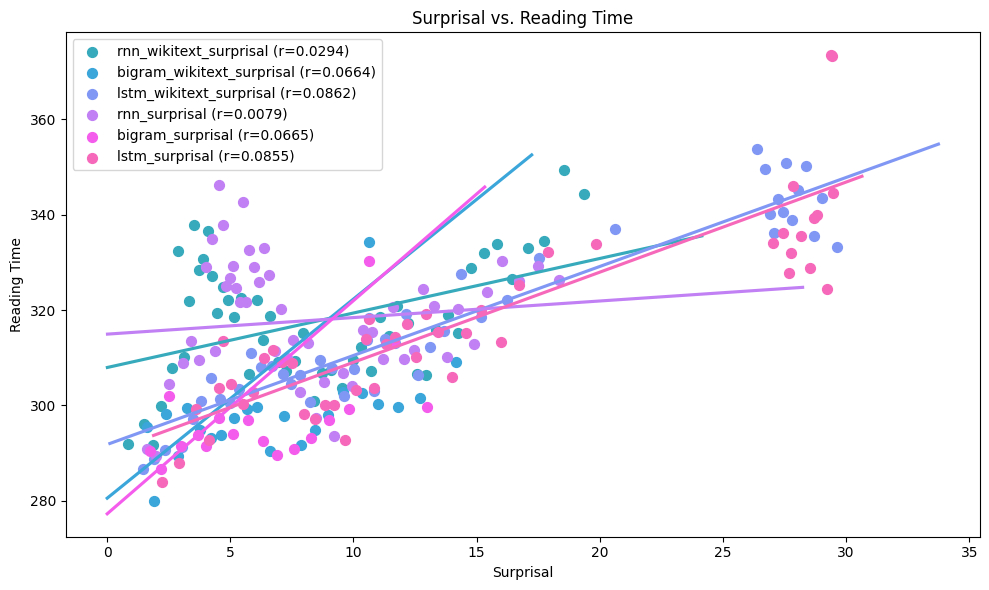

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
plt.figure(figsize=(10, 6))

palette = sns.color_palette("husl", len(surprisals_rt.columns))

filter_value = surprisals_rt['bigram_wikitext_surprisal'].max()
# List of columns where you want to replace the `filter_value`
columns_to_replace = ['rnn_wikitext_surprisal', 'bigram_wikitext_surprisal', 'lstm_wikitext_surprisal',
                      'rnn_surprisal', 'bigram_surprisal', 'lstm_surprisal']
mean_surprisal = surprisals_rt[columns_to_replace].stack().loc[lambda x: x != filter_value].mean()
surprisals_rt[columns_to_replace] = surprisals_rt[columns_to_replace].replace(filter_value, mean_surprisal)


for i, model in enumerate(surprisals_rt.columns):
    if 'surprisal' not in model:
        continue
    corr_ngram, _ = pearsonr(surprisals_rt[model], surprisals_rt['time'])
    sns.regplot(x=model,y="time",data=surprisals_rt,x_bins=50,color=palette[i],
        ci=None, label=f'{model} (r={corr_ngram:.4f})')

plt.title('Surprisal vs. Reading Time')
plt.xlabel('Surprisal')
plt.ylabel('Reading Time')
plt.legend()
plt.tight_layout()
plt.show()


With no pre-processing

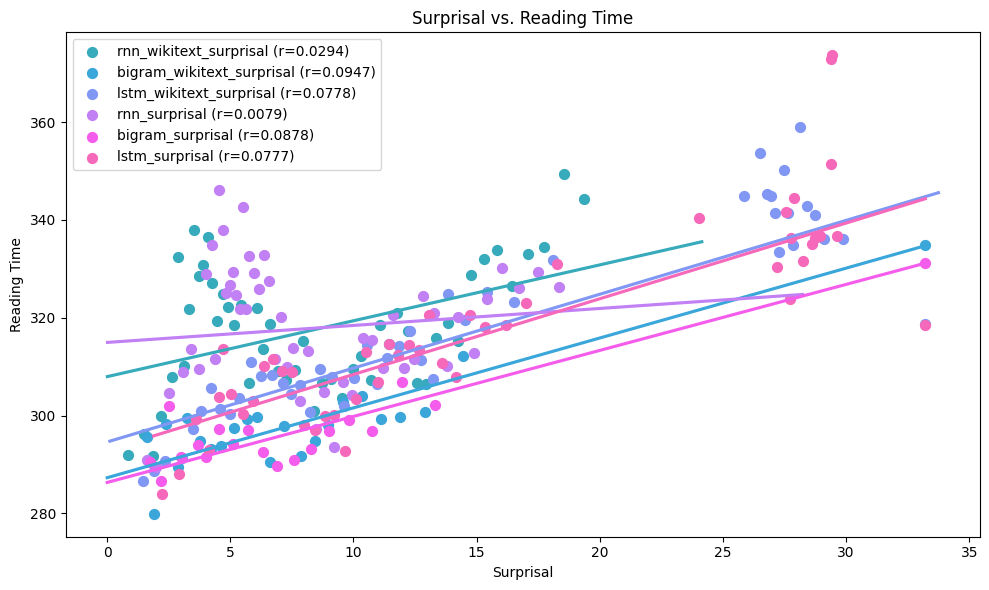

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
plt.figure(figsize=(10, 6))

palette = sns.color_palette("husl", len(surprisals_rt.columns))

for i, model in enumerate(surprisals_rt.columns):
    if 'surprisal' not in model:
        continue
    corr_ngram, _ = pearsonr(surprisals_rt_proc[model], surprisals_rt_proc['time'])
    sns.regplot(x=model,y="time",data=surprisals_rt_proc,x_bins=50,color=palette[i],
        ci=None, label=f'{model} (r={corr_ngram:.4f})')

plt.title('Surprisal vs. Reading Time')
plt.xlabel('Surprisal')
plt.ylabel('Reading Time')
plt.legend()
plt.tight_layout()
plt.show()


**We first want to try simple aggregation functions while filtering out the default values 33.219281**

In [35]:
from scipy.stats import gmean

# Aggregation functions
def mean_agg(x, filter_value):
    v = [w for w in x if w != filter_value and pd.notna(w)]
    if len(v) == 0:
        return filter_value
    return np.mean(v)

def max_agg(x, filter_value):
    v = [w for w in x if w != filter_value and pd.notna(w)]
    if len(v) == 0:
        return filter_value
    return np.max(v)

def min_agg(x, filter_value):
    v = [w for w in x if w != filter_value and pd.notna(w)]
    if len(v) == 0:
        return filter_value
    return np.min(v)

def minmax_agg(x, filter_value):
    v = [w for w in x if w != filter_value and pd.notna(w)]
    if len(v) == 0:
        return filter_value
    return (np.max(v) - np.min(v)) / 2

def geom_mean_agg(x, filter_value):
    v = [w for w in x if w != filter_value and pd.notna(w) and w > 0]
    if len(v) == 0:
        return filter_value
    return gmean(v)

agg_func_dict = {'Mean':mean_agg, "Max": max_agg, 'Min':min_agg, 'Mean(Max,Min)':minmax_agg, 'Geometric Mean':geom_mean_agg}


Mean
Max
Min
Mean(max,min)
Geometric mean


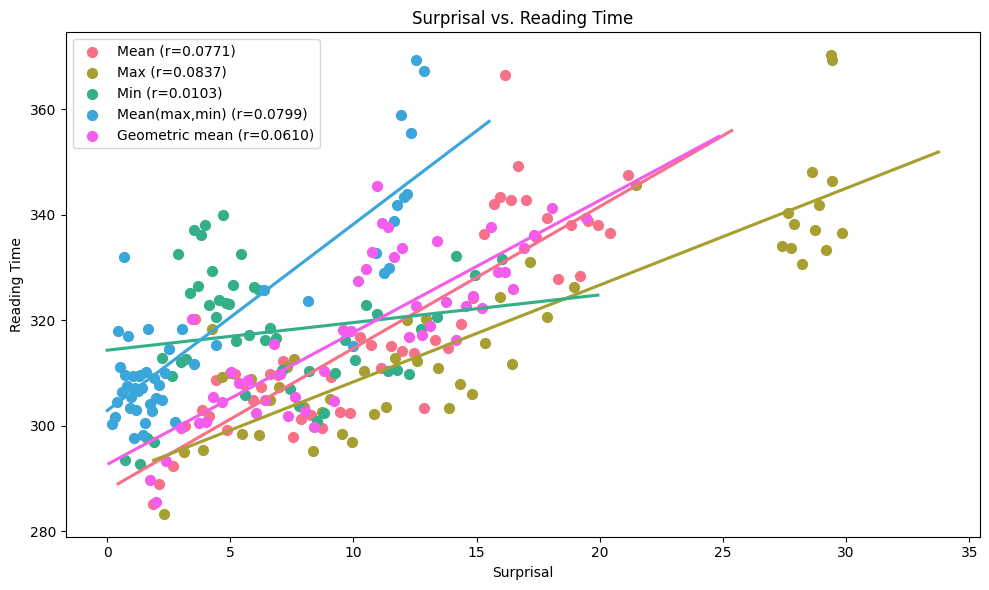

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
plt.figure(figsize=(10, 6))

agg_func_dict = {'Mean':mean_agg, "Max": max_agg, 'Min':min_agg, 'Mean(Max,Min)':minmax_agg, 'Geometric Mean':geom_mean_agg}
palette = sns.color_palette("husl", len(surprisals_rt.columns))
filter_value = surprisals_rt['bigram_wikitext_surprisal'].max()

surp_columns = ['rnn_wikitext_surprisal', 'bigram_wikitext_surprisal', 'lstm_wikitext_surprisal'] + ['rnn_surprisal', 'bigram_surprisal', 'lstm_surprisal']
for i,func in enumerate(agg_func_dict.keys()):
  print(func.capitalize())
  surprisals_rt_proc['surprisal'] = surprisals_rt_proc[surp_columns].apply(lambda x: agg_func[func](x, filter_value), axis=1)
  corr_ngram, _ = pearsonr(surprisals_rt_proc["surprisal"], surprisals_rt_proc['time'])
  sns.regplot(x="surprisal",y="time",data=surprisals_rt_proc,x_bins=50,color=palette[i*3],
      ci=None, label=f'{func.capitalize()} (r={corr_ngram:.4f})')

plt.title('Surprisal vs. Reading Time')
plt.xlabel('Surprisal')
plt.ylabel('Reading Time')
plt.legend()
plt.tight_layout()
plt.show()


We can see that between them the max aggragation present a better linear relashionship then others. This means that the models tend the underestimate the surprisal value.

## Analyzing the different surprisal values in prediction models

We want to see how are the surprisal values are able to predict the RT values using three different linear models.
We will also check for the feature importance when all surprisal values were not aggragated.

In [16]:
# Function to calculate feature importances using permutation importance
def calculate_feature_importances(model, X, y):
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    return result.importances_mean

def plot_feature_importances_subplots(feature_importances):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    for i, (model_name, importances) in enumerate(feature_importances.items()):
        axs[i].barh(surp_columns, importances)
        axs[i].set_title(model_name)
        axs[i].set_xlabel("Feature Importance")
        axs[i].set_ylabel("Features")

    plt.suptitle("Feature Importances for Linear Models")
    plt.tight_layout()
    plt.show()

def evaluate_models(X_train, X_test, y_train, y_test):
    results = {}
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        # Predict
        y_pred = model.predict(X_test)
        # Calculate MSE
        mse = mean_squared_error(y_test, y_pred)
        results[model_name] = mse
    return results


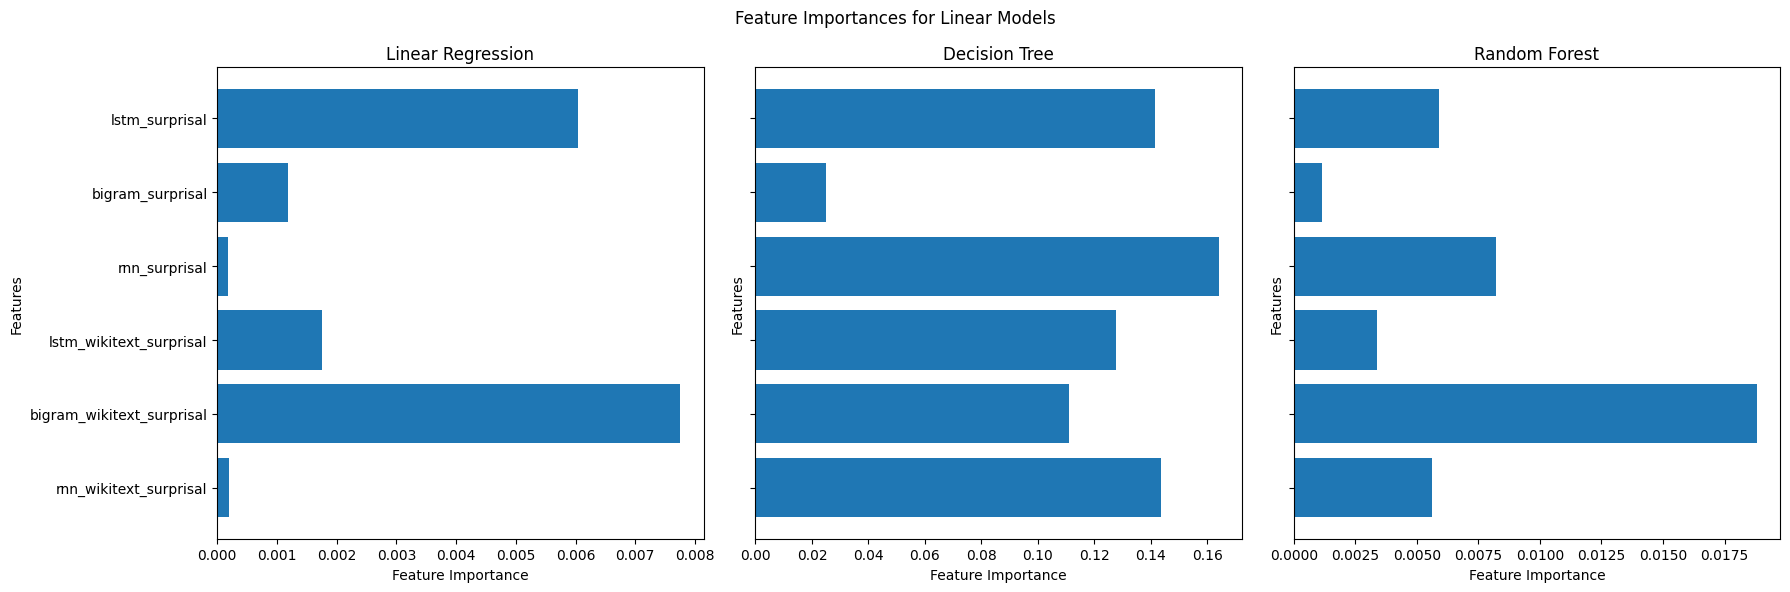

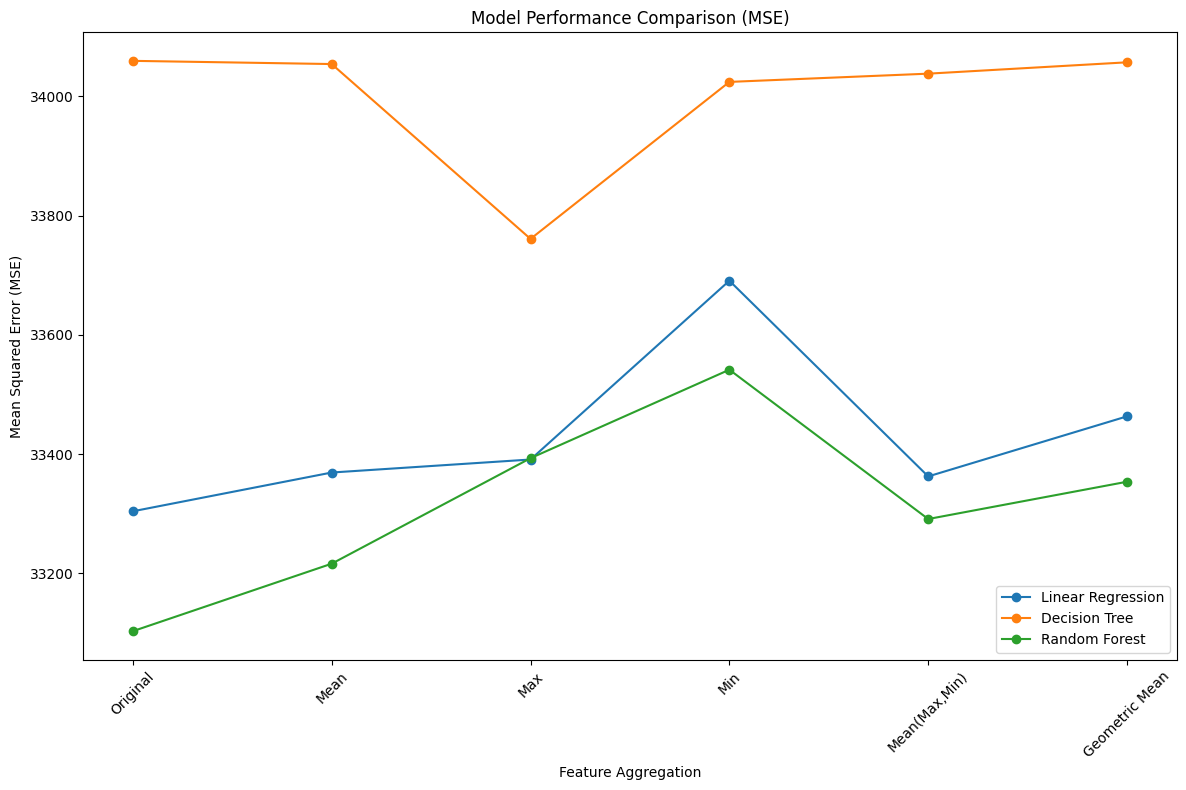

In [41]:
from sklearn.inspection import permutation_importance

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, max_depth=5, n_estimators=30),

}
# Prepare Data
surp_columns = ['rnn_wikitext_surprisal', 'bigram_wikitext_surprisal', 'lstm_wikitext_surprisal',
                'rnn_surprisal', 'bigram_surprisal', 'lstm_surprisal']
X = surprisals_rt_proc[surp_columns]
y = surprisals_rt_proc['time']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate models with original features
original_results = evaluate_models(X_train, X_test, y_train, y_test)

# Calculate feature importances for each model
feature_importances = {}
for model_name, model in models.items():
    feature_importances[model_name] = calculate_feature_importances(model, X_train, y_train)
plot_feature_importances_subplots(feature_importances)

# Evaluate models with aggregated features
agg_results = {}

for agg_name, func in agg_func_dict.items():
    print(f"\nEvaluating Aggregation: {agg_name}")

    # Apply aggregation function
    filter_value = X.max().max()  # Use the maximum value across all features for filtering
    X_agg = X.apply(lambda row: func(row, filter_value), axis=1)

    # Split the data
    X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(X_agg.values.reshape(-1, 1), y, test_size=0.2, random_state=42)

    # Evaluate models with aggregated features
    agg_results[agg_name] = evaluate_models(X_train_agg, X_test_agg, y_train_agg, y_test_agg)

# Plotting Model Performance Comparison
plt.figure(figsize=(12, 8))
for model_name in models.keys():
    mse_values = [original_results[model_name]] + [agg_results[agg_name][model_name] for agg_name in agg_func_dict.keys()]
    plt.plot(['Original'] + list(agg_func_dict.keys()), mse_values, marker='o', label=model_name)

plt.title('Model Performance Comparison (MSE)')
plt.xlabel('Feature Aggregation')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



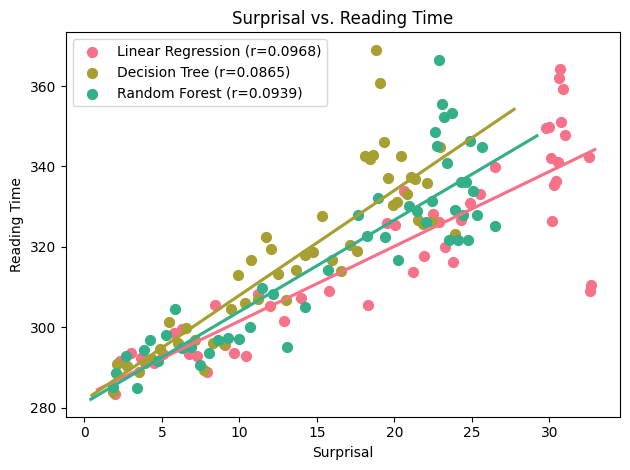

In [45]:
import numpy as np

# Define the aggregation function for weighted mean
feature_importances_df = pd.DataFrame(feature_importances, index=surp_columns)
filter_value = surprisals_rt['bigram_wikitext_surprisal'].max()

def agg_func(row, m, filter=True):

  weights = feature_importances_df[m]
  if filter:
    weights = [weights.iloc[i] for i in range(len(weights)) if row[i] != filter_value]
    row = [x for x in row if x != filter_value]
  else:
    weights = [weights.iloc[i] for i in range(len(weights))]
    row = [x for x in row]
  return np.average(row, weights=weights)

# Create the "surprisal_wm" column
for i,m in enumerate(feature_importances_df.columns):
  col_name = f'surprisal_wm_{m}'
  surprisals_rt_proc[col_name] = surprisals_rt_proc[surp_columns].apply(lambda x:agg_func(x,m, filter=False), axis=1)
  corr_ngram, _ = pearsonr(surprisals_rt_proc[col_name], surprisals_rt_proc['time'])
  sns.regplot(x=col_name,y="time",data=surprisals_rt_proc,x_bins=50,color=palette[i*3],
      ci=None, label=f'{m} (r={corr_ngram:.4f})')
plt.title('Surprisal vs. Reading Time')
plt.xlabel('Surprisal')
plt.ylabel('Reading Time')
plt.legend()
plt.tight_layout()
plt.show()

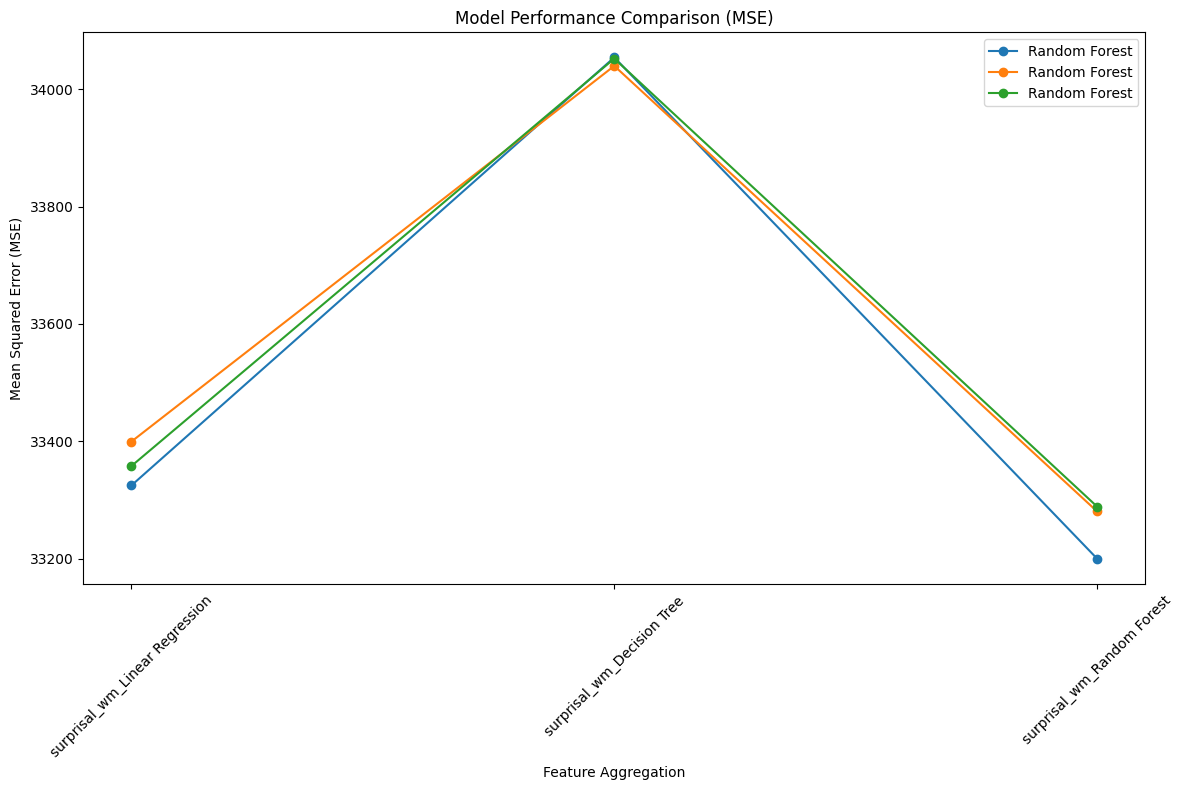

In [47]:
# Evaluate models with aggregated features
feature_importances_df = pd.DataFrame(feature_importances, index=surp_columns)
results = {}
for i,m in enumerate(feature_importances_df.columns):
  col_name = f'surprisal_wm_{m}'
  X_agg = surprisals_rt_proc[col_name]
  X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(X_agg.values.reshape(-1, 1), y, test_size=0.2, random_state=42)
  results[col_name] = evaluate_models(X_train_agg, X_test_agg, y_train_agg, y_test_agg)


# Plotting Model Performance Comparison
plt.figure(figsize=(12, 8))
for col in results.keys():
    mse_values = [results[col][model_name] for model_name in results[col].keys()]
    plt.plot(list(results.keys()), mse_values, marker='o', label=model_name)

plt.title('Model Performance Comparison (MSE)')
plt.xlabel('Feature Aggregation')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

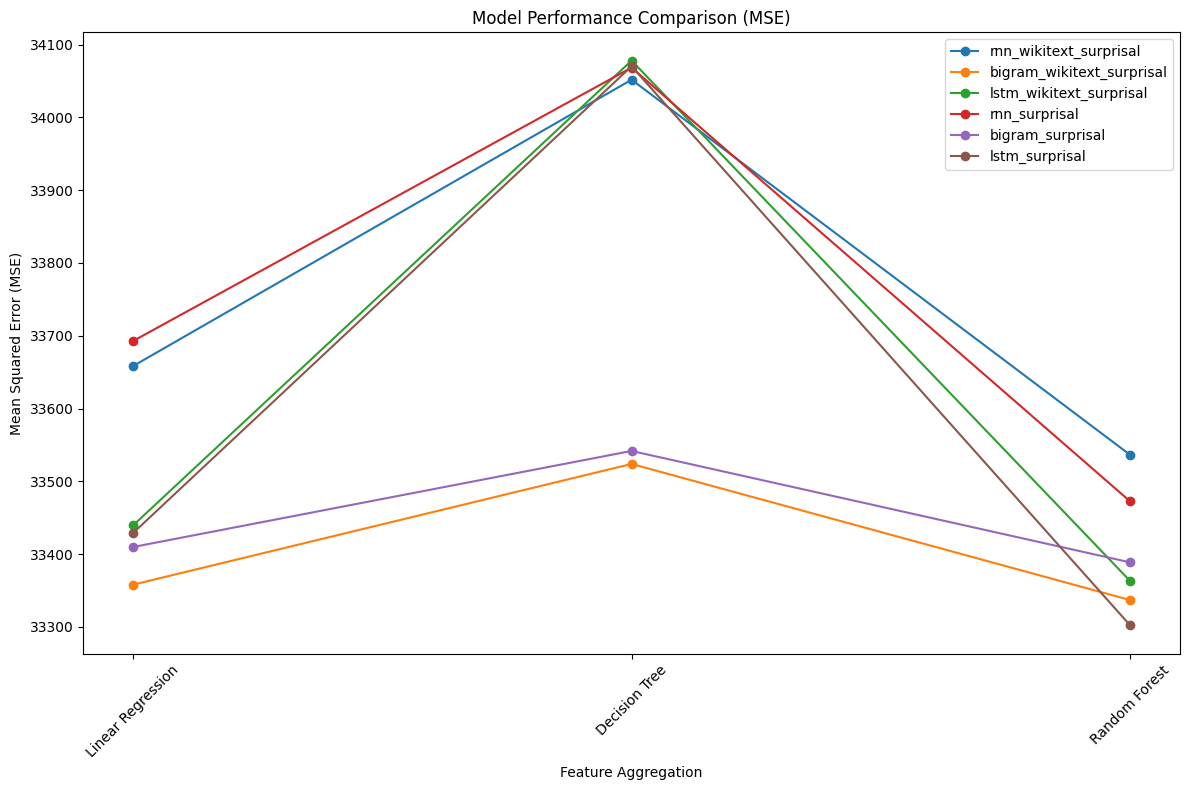

In [57]:
# Evaluate models with aggregated features
feature_importances_df = pd.DataFrame(feature_importances, index=surp_columns)
results = {}
for i,m in enumerate(surprisals_rt_proc.columns):
  if 'surprisal' not in m or 'wm' in m:
    continue
  X_agg = surprisals_rt_proc[m]
  X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(X_agg.values.reshape(-1, 1), y, test_size=0.2, random_state=42)
  results[m] = evaluate_models(X_train_agg, X_test_agg, y_train_agg, y_test_agg)


# Plotting Model Performance Comparison
plt.figure(figsize=(12, 8))
for col in results.keys():
    mse_values = [results[col][model_name] for model_name in results[col].keys()]
    plt.plot(list(results[col].keys()), mse_values, marker='o', label=col)

plt.title('Model Performance Comparison (MSE)')
plt.xlabel('Feature Aggregation')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()